In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = 'SR'
  %cd /content/gdrive/My\ Drive/$FOLDERNAME
except ImportError:
  pass

Mounted at /content/gdrive
/content/gdrive/My Drive/SR


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.init as init
from math import log10
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
from os import listdir
from os.path import join
from scipy.io import loadmat
from tqdm import tqdm

In [14]:
#Model

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)
        return out

In [15]:
# Parameters
BATCH_SIZE = 16
NUM_WORKERS = 0 # on Windows, set this variable to 0
scale_factor = 4
nb_epochs = 1000
cuda = True
CROP_SIZE = 64

device = torch.device("cuda:0" if (torch.cuda.is_available() and cuda) else "cpu")
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [16]:
class DatasetFromTensor(Dataset):
    def __init__(self, data, scale_factor, with_bicubic_upsampling = True):
        super(DatasetFromTensor, self).__init__()
        self.data = data

        crop_size = CROP_SIZE - (CROP_SIZE % scale_factor) # Valid crop size
        
        if with_bicubic_upsampling:
            self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size), # cropping the image
                                        transforms.Resize(crop_size//scale_factor),  # subsampling the image (half size)
                                        transforms.Resize(crop_size, interpolation=Image.BICUBIC)  # bicubic upsampling to get back the original size 
                                        ])
        else:
            self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size), # cropping the image
                                        transforms.Resize(crop_size//scale_factor)  # subsampling the image (half size)
                                        ])
                
        self.target_transform = transforms.Compose([transforms.CenterCrop(crop_size) # since it's the target, we keep its original quality
                                        ])

    def __getitem__(self, index):
        input = self.data[index]
        target = input.clone()

        GB = transforms.GaussianBlur(kernel_size=(3,3), sigma=(1,1))
        
        input = GB(input)
        input = self.input_transform(input)
        target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.data)


In [17]:
data = loadmat('ns_data_Ve5_SRCNN.mat')
w = torch.from_numpy(data['w'])[:256]
w = w.reshape(shape=(w.shape[0], 1, w.shape[1], w.shape[2]))

In [18]:
trainset = DatasetFromTensor(w[:200], scale_factor=scale_factor)
testset = DatasetFromTensor(w[200:], scale_factor=scale_factor)

trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
model = SRCNN().to(device)
model = model.float()

criterion = nn.MSELoss()

optimizer = optim.Adam(  # we use Adam instead of SGD like in the paper, because it's faster
    [
        {"params": model.conv1.parameters(), "lr": 0.0001},  
        {"params": model.conv2.parameters(), "lr": 0.0001},
        {"params": model.conv3.parameters(), "lr": 0.00001},
    ], lr=0.00001,
)


hist_loss_train = []
hist_loss_test = []
hist_psnr_train = []
hist_psnr_test = []


for epoch in range(nb_epochs):

    # Train
    avg_psnr = 0
    epoch_loss = 0
    for iteration, batch in enumerate(tqdm(trainloader)):
      input, target = batch[0].to(device), batch[1].to(device)
      input, target = input.float(), target.float()
      optimizer.zero_grad()

      out = model(input)
      loss = criterion(out, target)
      psnr = 10 * log10(1 / loss.item())
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      avg_psnr += psnr

    print(f"Epoch {epoch}. Training loss: {epoch_loss / len(trainloader)}")
    hist_loss_train.append(epoch_loss / len(trainloader))
    hist_psnr_train.append(avg_psnr / len(trainloader))

    # Test
    avg_psnr = 0
    epoch_loss = 0
    with torch.no_grad():
        for batch in testloader:
            input, target = batch[0].to(device), batch[1].to(device)
            input, target = input.float(), target.float()

            out = model(input)
            loss = criterion(out, target)
            psnr = 10 * log10(1 / loss.item())
            epoch_loss += loss.item()
            avg_psnr += psnr

    print(f"Average PSNR: {avg_psnr / len(testloader)} dB.")
    hist_loss_test.append(epoch_loss / len(testloader))
    hist_psnr_test.append(avg_psnr / len(testloader))

#torch.save(model, f"model_{epoch}.pth")

100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


Epoch 0. Training loss: 0.1223739288174189
Average PSNR: 9.48157343266334 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 1. Training loss: 0.10432692559865805
Average PSNR: 10.24041536993961 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 2. Training loss: 0.08670769058741055
Average PSNR: 11.236455541693175 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 3. Training loss: 0.06567942580351463
Average PSNR: 12.441377701631358 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 4. Training loss: 0.05025443004874083
Average PSNR: 13.81632784241842 dB.


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


Epoch 5. Training loss: 0.03613439402901209
Average PSNR: 15.580123440538506 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 6. Training loss: 0.022796114405187275
Average PSNR: 17.778332267130367 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 7. Training loss: 0.013728394638746977
Average PSNR: 20.395544911926617 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 8. Training loss: 0.00804739029934773
Average PSNR: 22.595209384749015 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 9. Training loss: 0.005474968616349192
Average PSNR: 23.64984477850058 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 10. Training loss: 0.004738551045123201
Average PSNR: 23.994491789301186 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 11. Training loss: 0.004309716150881006
Average PSNR: 24.342898962036955 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 12. Training loss: 0.003954959012424717
Average PSNR: 24.663111936526484 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 13. Training loss: 0.0037049500522418665
Average PSNR: 24.91552818560792 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 14. Training loss: 0.0035146599671301935
Average PSNR: 25.12778824705131 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 15. Training loss: 0.0033582991275649806
Average PSNR: 25.312675781961136 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 16. Training loss: 0.003236781769933609
Average PSNR: 25.473803359418586 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 17. Training loss: 0.0031362086391219725
Average PSNR: 25.61631719163521 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 18. Training loss: 0.0030284040392591404
Average PSNR: 25.761406410523307 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 19. Training loss: 0.002947201719507575
Average PSNR: 25.901450894289077 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 20. Training loss: 0.0028270558418276217
Average PSNR: 26.048516599078077 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 21. Training loss: 0.0027242625096383
Average PSNR: 26.186348061983246 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 22. Training loss: 0.0026310631790413307
Average PSNR: 26.33371945631921 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 23. Training loss: 0.0025342496720930706
Average PSNR: 26.483230101633108 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 24. Training loss: 0.0024801078968896316
Average PSNR: 26.631542418902068 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 25. Training loss: 0.0023786510305049326
Average PSNR: 26.786592367918445 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 26. Training loss: 0.002294850446140537
Average PSNR: 26.941844787652652 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 27. Training loss: 0.0022293355566664385
Average PSNR: 27.099697130456615 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 28. Training loss: 0.002192666333240385
Average PSNR: 27.258541500326523 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 29. Training loss: 0.00208316335024742
Average PSNR: 27.421683688365306 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 30. Training loss: 0.002000234304712369
Average PSNR: 27.590421028115397 dB.


100%|██████████| 13/13 [00:03<00:00,  3.31it/s]


Epoch 31. Training loss: 0.0019233326355998332
Average PSNR: 27.749704185786328 dB.


100%|██████████| 13/13 [00:03<00:00,  3.31it/s]


Epoch 32. Training loss: 0.0018506113511438554
Average PSNR: 27.90571594823308 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 33. Training loss: 0.001809200791355509
Average PSNR: 28.06241495700057 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 34. Training loss: 0.0017258972198200913
Average PSNR: 28.21378722249698 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 35. Training loss: 0.001691511465021624
Average PSNR: 28.360504097522526 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 36. Training loss: 0.0016377647855104161
Average PSNR: 28.50845833904038 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 37. Training loss: 0.001587739814287768
Average PSNR: 28.666567538527413 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 38. Training loss: 0.0015112637954119307
Average PSNR: 28.885956234811097 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 39. Training loss: 0.001440554543828162
Average PSNR: 29.08211425901543 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 40. Training loss: 0.001391999307088554
Average PSNR: 29.27467861055851 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 41. Training loss: 0.0013176235728538954
Average PSNR: 29.448491019252653 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 42. Training loss: 0.0012763675185851753
Average PSNR: 29.61684784358091 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 43. Training loss: 0.0012310644557986122
Average PSNR: 29.762628278678378 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 44. Training loss: 0.0012103303228146755
Average PSNR: 29.91105225922982 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 45. Training loss: 0.0011451303278310941
Average PSNR: 30.05435574950079 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 46. Training loss: 0.0011290942067996813
Average PSNR: 30.190374816111856 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 47. Training loss: 0.0010805453908128233
Average PSNR: 30.317922971530454 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 48. Training loss: 0.0010682705950994904
Average PSNR: 30.447467196823023 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 49. Training loss: 0.0010261589240354414
Average PSNR: 30.56483172491297 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 50. Training loss: 0.0010113186883525206
Average PSNR: 30.683789769235354 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 51. Training loss: 0.0009719997536964142
Average PSNR: 30.804449478244237 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 52. Training loss: 0.0009627941180951893
Average PSNR: 30.909938792744683 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 53. Training loss: 0.000936465051311713
Average PSNR: 31.00924482041264 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 54. Training loss: 0.0009225031647544641
Average PSNR: 31.127701164088776 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 55. Training loss: 0.0009054668704406
Average PSNR: 31.23700404756786 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 56. Training loss: 0.0008740832563489676
Average PSNR: 31.33927591080457 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 57. Training loss: 0.0008470249371244931
Average PSNR: 31.443041935629658 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 58. Training loss: 0.0008229526529948299
Average PSNR: 31.54391938802773 dB.


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


Epoch 59. Training loss: 0.000813743238373158
Average PSNR: 31.64620398981971 dB.


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


Epoch 60. Training loss: 0.0007900779287760648
Average PSNR: 31.746253744597734 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 61. Training loss: 0.0007816663486524844
Average PSNR: 31.840212046152754 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 62. Training loss: 0.0007562525033091123
Average PSNR: 31.934922481692873 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 63. Training loss: 0.0007446139576271749
Average PSNR: 32.02809270100604 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 64. Training loss: 0.0007254828904898694
Average PSNR: 32.12042626621083 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 65. Training loss: 0.0007315327843221334
Average PSNR: 32.21166977790753 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 66. Training loss: 0.0007111859561588902
Average PSNR: 32.289188010778616 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 67. Training loss: 0.0006990433992961278
Average PSNR: 32.3870259377463 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 68. Training loss: 0.0006887462491599413
Average PSNR: 32.47847368572356 dB.


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 69. Training loss: 0.0006603448418900371
Average PSNR: 32.559893941903304 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 70. Training loss: 0.0006498536677099764
Average PSNR: 32.64550967360549 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 71. Training loss: 0.0006434038469496255
Average PSNR: 32.72302793007128 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 72. Training loss: 0.000621208336759502
Average PSNR: 32.80920998327859 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 73. Training loss: 0.0006141118736615261
Average PSNR: 32.88566326335742 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 74. Training loss: 0.000608418844282054
Average PSNR: 32.95091014375242 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 75. Training loss: 0.0006081849770942846
Average PSNR: 33.0369844871726 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 76. Training loss: 0.0005839846473043928
Average PSNR: 33.09749134789788 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 77. Training loss: 0.0005788725930660104
Average PSNR: 33.1690923630463 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 78. Training loss: 0.0005802710858496049
Average PSNR: 33.248329148908496 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 79. Training loss: 0.0005654650113473718
Average PSNR: 33.32246375085273 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 80. Training loss: 0.0005613373225339904
Average PSNR: 33.38884199001007 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 81. Training loss: 0.0005543486264426834
Average PSNR: 33.4331217496341 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 82. Training loss: 0.0005428714682168972
Average PSNR: 33.52435409104466 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 83. Training loss: 0.0005488378855471427
Average PSNR: 33.58762362622054 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 84. Training loss: 0.0005250163242005958
Average PSNR: 33.63098656458341 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 85. Training loss: 0.000514354319490779
Average PSNR: 33.712469986872186 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 86. Training loss: 0.0005099539927099473
Average PSNR: 33.76737198289062 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 87. Training loss: 0.0005106461086632827
Average PSNR: 33.83065124268906 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 88. Training loss: 0.0004991525157283132
Average PSNR: 33.883572859216514 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 89. Training loss: 0.0004895166941703513
Average PSNR: 33.9506947225428 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 90. Training loss: 0.0004954297283592706
Average PSNR: 34.0067925275343 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 91. Training loss: 0.0004904797018613094
Average PSNR: 34.076234602347554 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 92. Training loss: 0.0004707480144973558
Average PSNR: 34.11304374940075 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 93. Training loss: 0.00046327255012539145
Average PSNR: 34.18082282067848 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 94. Training loss: 0.0004596958035388245
Average PSNR: 34.25036979066966 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 95. Training loss: 0.0004512345722804849
Average PSNR: 34.30962626525374 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 96. Training loss: 0.0004517285717436327
Average PSNR: 34.37237809954407 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 97. Training loss: 0.00044293045917024405
Average PSNR: 34.39954073209222 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 98. Training loss: 0.00043653106191553746
Average PSNR: 34.48473603087524 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 99. Training loss: 0.00043256680902022007
Average PSNR: 34.54736292006989 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 100. Training loss: 0.00043060776750700403
Average PSNR: 34.61149520082473 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 101. Training loss: 0.000419549220868458
Average PSNR: 34.66647723669086 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 102. Training loss: 0.000410860614815297
Average PSNR: 34.71052143584987 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 103. Training loss: 0.0004137531796004623
Average PSNR: 34.744783649392886 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 104. Training loss: 0.0004090456283078171
Average PSNR: 34.84421277620365 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 105. Training loss: 0.00040002140135934146
Average PSNR: 34.893196016330464 dB.


100%|██████████| 13/13 [00:03<00:00,  3.31it/s]


Epoch 106. Training loss: 0.00039695322629995644
Average PSNR: 34.95329123714516 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 107. Training loss: 0.00039951476187875064
Average PSNR: 35.01785513560784 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 108. Training loss: 0.00039817809010855854
Average PSNR: 35.07241791095371 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 109. Training loss: 0.0003827365469008398
Average PSNR: 35.11571553099042 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 110. Training loss: 0.00037945059459441557
Average PSNR: 35.17818846127773 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 111. Training loss: 0.0003798327077395068
Average PSNR: 35.256947552562146 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 112. Training loss: 0.00036686156146550696
Average PSNR: 35.276892768764824 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 113. Training loss: 0.0003647481095798027
Average PSNR: 35.37314280762249 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 114. Training loss: 0.000354939769469918
Average PSNR: 35.43659857188109 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 115. Training loss: 0.0003534575181010251
Average PSNR: 35.491459160356804 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 116. Training loss: 0.00035391059310103837
Average PSNR: 35.54560301288864 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 117. Training loss: 0.0003360591799719259
Average PSNR: 35.61410459723805 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 118. Training loss: 0.00033167770016007125
Average PSNR: 35.67215912531465 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 119. Training loss: 0.0003315172574590318
Average PSNR: 35.72452640862586 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 120. Training loss: 0.00032881839433684945
Average PSNR: 35.812504130377604 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 121. Training loss: 0.00032325942055859533
Average PSNR: 35.83547804766723 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 122. Training loss: 0.0003172542492393404
Average PSNR: 35.89522989402101 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 123. Training loss: 0.0003242490325087252
Average PSNR: 35.98355707547166 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 124. Training loss: 0.0003148953793033098
Average PSNR: 36.04761207150452 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 125. Training loss: 0.00030118951802321064
Average PSNR: 36.066765111791995 dB.


100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 126. Training loss: 0.00029708250748136867
Average PSNR: 36.15579039982569 dB.


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


Epoch 127. Training loss: 0.0002986191550287633
Average PSNR: 36.1215839192906 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 128. Training loss: 0.00029357987379905983
Average PSNR: 36.25507110912836 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 129. Training loss: 0.00029220796512583125
Average PSNR: 36.34521417813357 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 130. Training loss: 0.0002860353594699588
Average PSNR: 36.394003066352184 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 131. Training loss: 0.00027928177083734994
Average PSNR: 36.477479983249374 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 132. Training loss: 0.00028949123113237036
Average PSNR: 36.54032255427824 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 133. Training loss: 0.0002724018346410818
Average PSNR: 36.526802904929205 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 134. Training loss: 0.00026930811985109287
Average PSNR: 36.627884570565875 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 135. Training loss: 0.0002671714319149032
Average PSNR: 36.702327433951126 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 136. Training loss: 0.00026505123465680157
Average PSNR: 36.744077295501434 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 137. Training loss: 0.00026060368691105396
Average PSNR: 36.79685677821294 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 138. Training loss: 0.00025775309432691964
Average PSNR: 36.86502375520998 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 139. Training loss: 0.0002530444628344132
Average PSNR: 36.89999476597284 dB.


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]


Epoch 140. Training loss: 0.00025234604702116206
Average PSNR: 36.96259047381292 dB.


100%|██████████| 13/13 [00:03<00:00,  3.32it/s]


Epoch 141. Training loss: 0.0002461622487037228
Average PSNR: 37.03146331879841 dB.


100%|██████████| 13/13 [00:03<00:00,  3.32it/s]


Epoch 142. Training loss: 0.00024224449813258476
Average PSNR: 37.068575654543366 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 143. Training loss: 0.00024396548262582376
Average PSNR: 37.1341116244496 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 144. Training loss: 0.00024206848264349482
Average PSNR: 37.158528262224046 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 145. Training loss: 0.00024953893220159586
Average PSNR: 37.216777926351355 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 146. Training loss: 0.00023991448688320816
Average PSNR: 37.287225736099835 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 147. Training loss: 0.0002300281865665546
Average PSNR: 37.34099355041471 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 148. Training loss: 0.00023022947425488383
Average PSNR: 37.37914371057913 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 149. Training loss: 0.00022886222219452835
Average PSNR: 37.44088849797255 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 150. Training loss: 0.00022371683735400438
Average PSNR: 37.51290014264242 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 151. Training loss: 0.000233258272951039
Average PSNR: 37.52985083491053 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 152. Training loss: 0.00022082404085757354
Average PSNR: 37.59799067120552 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 153. Training loss: 0.00021687670960091054
Average PSNR: 37.646266106177706 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 154. Training loss: 0.00021767929138150066
Average PSNR: 37.69340868379121 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 155. Training loss: 0.00021879206402585484
Average PSNR: 37.75164459293907 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 156. Training loss: 0.0002093732171208383
Average PSNR: 37.74790597498303 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 157. Training loss: 0.00022009999016658045
Average PSNR: 37.834304335612586 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 158. Training loss: 0.00020707973789495343
Average PSNR: 37.84689902919882 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 159. Training loss: 0.0002035040267331239
Average PSNR: 37.9742702482565 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 160. Training loss: 0.00020091230824338988
Average PSNR: 38.001876519884995 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 161. Training loss: 0.00019785134533706767
Average PSNR: 38.03497712764208 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 162. Training loss: 0.00019909809186803893
Average PSNR: 38.08682496069132 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 163. Training loss: 0.00019425859556157285
Average PSNR: 38.099244725632104 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 164. Training loss: 0.00019349678376994023
Average PSNR: 38.21275021436403 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 165. Training loss: 0.00019434611917509197
Average PSNR: 38.24910452308917 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 166. Training loss: 0.00018867021739984362
Average PSNR: 38.30589526817269 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 167. Training loss: 0.0001897177845911266
Average PSNR: 38.3720844502734 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 168. Training loss: 0.00018250531194588312
Average PSNR: 38.39106402103066 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 169. Training loss: 0.00019182844754630842
Average PSNR: 38.47087868903072 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 170. Training loss: 0.00018143806664738804
Average PSNR: 38.4914272248603 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 171. Training loss: 0.00017726244550431147
Average PSNR: 38.585818623683714 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 172. Training loss: 0.00017985473319780655
Average PSNR: 38.5963264439788 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 173. Training loss: 0.00017218379406795764
Average PSNR: 38.6793943110796 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 174. Training loss: 0.0001764680502954154
Average PSNR: 38.730127458386875 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 175. Training loss: 0.00017025317132580452
Average PSNR: 38.75014282391662 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 176. Training loss: 0.00016804826680946953
Average PSNR: 38.82728114004898 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 177. Training loss: 0.0001659590046843872
Average PSNR: 38.87813888953059 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 178. Training loss: 0.00016870486825400105
Average PSNR: 38.91793941816448 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 179. Training loss: 0.0001637233514114856
Average PSNR: 38.966389920760506 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 180. Training loss: 0.00016059804777167021
Average PSNR: 39.01668674047846 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 181. Training loss: 0.0001694301872003752
Average PSNR: 39.08160178967506 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 182. Training loss: 0.0001614859826916542
Average PSNR: 39.08320039821156 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 183. Training loss: 0.00015876013919926033
Average PSNR: 39.1755285245916 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 184. Training loss: 0.00015512115407126167
Average PSNR: 39.20920145320913 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 185. Training loss: 0.00015158890164457262
Average PSNR: 39.280805092626096 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 186. Training loss: 0.0001495144763164437
Average PSNR: 39.31793272048694 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 187. Training loss: 0.00014869164498612427
Average PSNR: 39.38088253099739 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 188. Training loss: 0.00015671166049567267
Average PSNR: 39.41988005185585 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 189. Training loss: 0.00014626973167581198
Average PSNR: 39.50044197105865 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 190. Training loss: 0.00014432457828661427
Average PSNR: 39.52006089385741 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 191. Training loss: 0.0001416844897903502
Average PSNR: 39.60364084018371 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 192. Training loss: 0.00014849372942430468
Average PSNR: 39.63585664136061 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 193. Training loss: 0.00013813438832025544
Average PSNR: 39.69778000389327 dB.


100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


Epoch 194. Training loss: 0.0001379124341138567
Average PSNR: 39.71355181480034 dB.


100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


Epoch 195. Training loss: 0.00013945115698823848
Average PSNR: 39.809919264759465 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 196. Training loss: 0.00013366725033847615
Average PSNR: 39.827893973170504 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 197. Training loss: 0.00013351968832117005
Average PSNR: 39.90152587232909 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 198. Training loss: 0.00013442284958168434
Average PSNR: 39.95422698135371 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 199. Training loss: 0.00013034789802846857
Average PSNR: 40.03766011516812 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 200. Training loss: 0.00012911312212683976
Average PSNR: 40.04461076061992 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 201. Training loss: 0.00012651228070563564
Average PSNR: 40.151558941759184 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 202. Training loss: 0.00012673200902869352
Average PSNR: 40.153345466360584 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 203. Training loss: 0.00013008158174880708
Average PSNR: 40.22055657032521 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 204. Training loss: 0.0001217298519734938
Average PSNR: 40.293502169266915 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 205. Training loss: 0.00012069269891631288
Average PSNR: 40.346289322277414 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 206. Training loss: 0.00011862513033870178
Average PSNR: 40.392448380257825 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 207. Training loss: 0.00011833735390190178
Average PSNR: 40.44916935882747 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 208. Training loss: 0.00011769818565181385
Average PSNR: 40.45953546231364 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 209. Training loss: 0.00011522029392206325
Average PSNR: 40.53581535857896 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 210. Training loss: 0.00012161744178648895
Average PSNR: 40.6057010243581 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 211. Training loss: 0.00011425917742039579
Average PSNR: 40.65983036407853 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 212. Training loss: 0.00011088027419576135
Average PSNR: 40.70704020740153 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 213. Training loss: 0.00010975749375155338
Average PSNR: 40.7517804299132 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 214. Training loss: 0.00010813155789107371
Average PSNR: 40.793371198619305 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 215. Training loss: 0.00010683590573115417
Average PSNR: 40.85597134665454 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 216. Training loss: 0.00010715641054468087
Average PSNR: 40.867292686953974 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 217. Training loss: 0.00010626030976149756
Average PSNR: 40.94894894540476 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 218. Training loss: 0.00010718381068167779
Average PSNR: 41.003257466060596 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 219. Training loss: 0.00010171813706759937
Average PSNR: 41.03565402898393 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 220. Training loss: 0.00010189151698096584
Average PSNR: 41.10750320024713 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 221. Training loss: 9.903427585063932e-05
Average PSNR: 41.17221745869942 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 222. Training loss: 9.967065908802816e-05
Average PSNR: 41.22342018791058 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 223. Training loss: 9.800081002490166e-05
Average PSNR: 41.2663404945895 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 224. Training loss: 9.447363089958134e-05
Average PSNR: 41.33067285303521 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 225. Training loss: 9.43444353582051e-05
Average PSNR: 41.38508396006704 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 226. Training loss: 9.40491540509706e-05
Average PSNR: 41.40315347039355 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 227. Training loss: 9.2078893290958e-05
Average PSNR: 41.465371625108865 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 228. Training loss: 9.055043595323626e-05
Average PSNR: 41.514873481679814 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 229. Training loss: 9.047338132334586e-05
Average PSNR: 41.55278303217075 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 230. Training loss: 9.063166558357458e-05
Average PSNR: 41.5371136925904 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 231. Training loss: 9.088977486289178e-05
Average PSNR: 41.641490436314626 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 232. Training loss: 8.803621452758447e-05
Average PSNR: 41.687121891567514 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 233. Training loss: 8.716156130853611e-05
Average PSNR: 41.6877038269761 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 234. Training loss: 8.6143994289719e-05
Average PSNR: 41.74286660815695 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 235. Training loss: 8.736640470138249e-05
Average PSNR: 41.79365634462124 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 236. Training loss: 8.539977044655153e-05
Average PSNR: 41.816544397898625 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 237. Training loss: 8.391591780729449e-05
Average PSNR: 41.867139895556214 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 238. Training loss: 8.33467549035469e-05
Average PSNR: 41.87056269969295 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 239. Training loss: 8.186921135907491e-05
Average PSNR: 41.9540736495204 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 240. Training loss: 8.227472146525263e-05
Average PSNR: 41.96754507979726 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 241. Training loss: 8.112666126600324e-05
Average PSNR: 42.01831813117391 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 242. Training loss: 8.103143465212689e-05
Average PSNR: 42.044137556860065 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 243. Training loss: 7.965282873975902e-05
Average PSNR: 42.07107811981405 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 244. Training loss: 7.985624744413563e-05
Average PSNR: 42.10680501954147 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 245. Training loss: 7.82297149551316e-05
Average PSNR: 42.099175998400554 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 246. Training loss: 7.826873563597194e-05
Average PSNR: 42.16207303974994 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 247. Training loss: 7.833941456808064e-05
Average PSNR: 42.218315756194414 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 248. Training loss: 7.703262123798665e-05
Average PSNR: 42.18570338658161 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 249. Training loss: 7.677428416522722e-05
Average PSNR: 42.28757969668527 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 250. Training loss: 7.472942664977521e-05
Average PSNR: 42.314677469408196 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 251. Training loss: 7.436089967646134e-05
Average PSNR: 42.370126225072276 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 252. Training loss: 7.523503546298553e-05
Average PSNR: 42.40217320070725 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 253. Training loss: 7.438124661208488e-05
Average PSNR: 42.39766214245241 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 254. Training loss: 7.341553618271764e-05
Average PSNR: 42.440890058251 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 255. Training loss: 7.774760496641438e-05
Average PSNR: 42.49221632145901 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 256. Training loss: 7.173557997493145e-05
Average PSNR: 42.555835715580756 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 257. Training loss: 7.26249678476821e-05
Average PSNR: 42.590849004775436 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 258. Training loss: 7.24565937931542e-05
Average PSNR: 42.58223147303532 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 259. Training loss: 7.111936625173817e-05
Average PSNR: 42.65309045569247 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 260. Training loss: 7.007071242416994e-05
Average PSNR: 42.673693352511215 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 261. Training loss: 6.877074869967495e-05
Average PSNR: 42.699781269097855 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 262. Training loss: 6.946811369673994e-05
Average PSNR: 42.77437348080212 dB.


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 263. Training loss: 6.74235743645113e-05
Average PSNR: 42.80677849490138 dB.


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Epoch 264. Training loss: 6.793191697887288e-05
Average PSNR: 42.83687706930331 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 265. Training loss: 6.661672131695713e-05
Average PSNR: 42.85709544899525 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 266. Training loss: 6.619003873381119e-05
Average PSNR: 42.89232925044365 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 267. Training loss: 6.595622135836702e-05
Average PSNR: 42.93024339856247 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 268. Training loss: 6.440160919177848e-05
Average PSNR: 42.987974420204296 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 269. Training loss: 6.466720795008139e-05
Average PSNR: 43.00933133241453 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 270. Training loss: 6.406015073970103e-05
Average PSNR: 43.0205018249751 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 271. Training loss: 6.374521707095063e-05
Average PSNR: 43.01042023098625 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 272. Training loss: 6.434915765287139e-05
Average PSNR: 43.088098251298106 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 273. Training loss: 6.272167173357538e-05
Average PSNR: 43.13240012525302 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 274. Training loss: 6.682486519611512e-05
Average PSNR: 43.1546996452815 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 275. Training loss: 6.183722675464545e-05
Average PSNR: 43.181101821061525 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 276. Training loss: 6.1015535790759786e-05
Average PSNR: 43.23063974122518 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 277. Training loss: 6.191680306353822e-05
Average PSNR: 43.214177241111315 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 278. Training loss: 6.181416728605445e-05
Average PSNR: 43.25810553010487 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 279. Training loss: 6.0392240322051715e-05
Average PSNR: 43.3075163971462 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 280. Training loss: 6.099630851307526e-05
Average PSNR: 43.35783201101754 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 281. Training loss: 5.891861152262069e-05
Average PSNR: 43.39343969102369 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 282. Training loss: 5.913405094850952e-05
Average PSNR: 43.40607352807727 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 283. Training loss: 5.833983120212976e-05
Average PSNR: 43.40064294971572 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 284. Training loss: 5.765093094221531e-05
Average PSNR: 43.470457903540535 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 285. Training loss: 5.9603111507245696e-05
Average PSNR: 43.555711159616294 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 286. Training loss: 5.720066026417324e-05
Average PSNR: 43.539112409801774 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 287. Training loss: 5.8688882675666646e-05
Average PSNR: 43.584648036063825 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 288. Training loss: 5.519154980832424e-05
Average PSNR: 43.60458129931661 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 289. Training loss: 5.5639875007238094e-05
Average PSNR: 43.59958005793778 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 290. Training loss: 5.450181505204035e-05
Average PSNR: 43.639677156633695 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 291. Training loss: 5.473814515146212e-05
Average PSNR: 43.71860160104273 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 292. Training loss: 5.388848540650752e-05
Average PSNR: 43.73470661369272 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 293. Training loss: 5.309394188001394e-05
Average PSNR: 43.78876727714343 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 294. Training loss: 5.2426712780008806e-05
Average PSNR: 43.778357539144466 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 295. Training loss: 5.2698582574241577e-05
Average PSNR: 43.825456842012564 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 296. Training loss: 5.318037969678139e-05
Average PSNR: 43.851961492551986 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 297. Training loss: 5.2573053555813836e-05
Average PSNR: 43.8787220515113 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 298. Training loss: 5.337762671003405e-05
Average PSNR: 43.94662060259967 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 299. Training loss: 5.086616343200708e-05
Average PSNR: 43.9540311714912 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 300. Training loss: 5.033228696377661e-05
Average PSNR: 44.002643563177955 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 301. Training loss: 5.00604261245686e-05
Average PSNR: 44.0386673026511 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 302. Training loss: 4.97644541610498e-05
Average PSNR: 44.07447640165175 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 303. Training loss: 4.9020647845911575e-05
Average PSNR: 44.05464931221454 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 304. Training loss: 4.9094564299314065e-05
Average PSNR: 44.125041531850584 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 305. Training loss: 5.1195475792225734e-05
Average PSNR: 44.156867178891716 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 306. Training loss: 4.810624131306003e-05
Average PSNR: 44.177091361078126 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 307. Training loss: 4.808799572996437e-05
Average PSNR: 44.17334737715394 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 308. Training loss: 4.9869674302709216e-05
Average PSNR: 44.26047038612997 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 309. Training loss: 4.751162459097731e-05
Average PSNR: 44.26372598459209 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 310. Training loss: 4.718443709022652e-05
Average PSNR: 44.31886470813342 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 311. Training loss: 4.609454873179157e-05
Average PSNR: 44.355263501011 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 312. Training loss: 4.656593004116215e-05
Average PSNR: 44.36441024123525 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 313. Training loss: 4.590469940852087e-05
Average PSNR: 44.38988525028112 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 314. Training loss: 4.581046120550197e-05
Average PSNR: 44.37761485944466 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 315. Training loss: 4.5599428351404363e-05
Average PSNR: 44.484993163329655 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 316. Training loss: 4.665818862402095e-05
Average PSNR: 44.508180489887465 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 317. Training loss: 4.592380999103905e-05
Average PSNR: 44.553435285264285 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 318. Training loss: 4.4997878761093416e-05
Average PSNR: 44.57805844753583 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 319. Training loss: 4.353489286866254e-05
Average PSNR: 44.62695911522289 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 320. Training loss: 4.294176575897906e-05
Average PSNR: 44.63444927041797 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 321. Training loss: 4.2913845950701776e-05
Average PSNR: 44.6645298690249 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 322. Training loss: 4.314954751932349e-05
Average PSNR: 44.71968010503997 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 323. Training loss: 4.2070977472646446e-05
Average PSNR: 44.73790043563058 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 324. Training loss: 4.166549507107657e-05
Average PSNR: 44.78491195972515 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 325. Training loss: 4.3478405971724824e-05
Average PSNR: 44.73534565570947 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 326. Training loss: 4.12032553028369e-05
Average PSNR: 44.681917812489786 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 327. Training loss: 4.1322666780056e-05
Average PSNR: 44.668889898273356 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 328. Training loss: 4.092232973981971e-05
Average PSNR: 44.86621699655198 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 329. Training loss: 4.0528436259662085e-05
Average PSNR: 44.82643535460453 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 330. Training loss: 3.966814564102186e-05
Average PSNR: 44.95174945071251 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 331. Training loss: 3.92599404921594e-05
Average PSNR: 44.9854760196274 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 332. Training loss: 3.982316509511573e-05
Average PSNR: 44.9950624327618 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 333. Training loss: 3.884108152236037e-05
Average PSNR: 45.0238651019474 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 334. Training loss: 3.8570382317769916e-05
Average PSNR: 45.0613173813872 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 335. Training loss: 3.7998225637308606e-05
Average PSNR: 45.08176071379697 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 336. Training loss: 3.848446948932878e-05
Average PSNR: 45.07690403946131 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 337. Training loss: 3.783647536273258e-05
Average PSNR: 45.14833604982955 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 338. Training loss: 3.862357922256566e-05
Average PSNR: 45.159149849561786 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 339. Training loss: 3.7075374935879015e-05
Average PSNR: 45.18545476004514 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 340. Training loss: 3.683363362282622e-05
Average PSNR: 45.21758860377628 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 341. Training loss: 3.687883578934886e-05
Average PSNR: 45.24482872811946 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 342. Training loss: 3.6486428563456196e-05
Average PSNR: 45.28049802533958 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 343. Training loss: 3.6013314037028555e-05
Average PSNR: 45.317539134800725 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 344. Training loss: 3.6305413791873994e-05
Average PSNR: 45.3261060828891 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 345. Training loss: 3.541745284634929e-05
Average PSNR: 45.34913853164534 dB.


100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 346. Training loss: 3.525980411303373e-05
Average PSNR: 45.3712075603454 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 347. Training loss: 3.4982851362796144e-05
Average PSNR: 45.40146178795691 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 348. Training loss: 3.480219745072715e-05
Average PSNR: 45.4243687987573 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 349. Training loss: 3.449864198046271e-05
Average PSNR: 45.437076643238534 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 350. Training loss: 3.441939658771914e-05
Average PSNR: 45.48554768976825 dB.


100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 351. Training loss: 3.390840776354218e-05
Average PSNR: 45.481153738801666 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 352. Training loss: 3.386582312277124e-05
Average PSNR: 45.515310033714 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 353. Training loss: 3.3632914822262064e-05
Average PSNR: 45.51410661447159 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 354. Training loss: 3.449650984503723e-05
Average PSNR: 45.436397864053305 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 355. Training loss: 3.350203867459921e-05
Average PSNR: 45.56211998916239 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 356. Training loss: 3.283449978670642e-05
Average PSNR: 45.613201009903705 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 357. Training loss: 3.3885362846866395e-05
Average PSNR: 45.613543659708455 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 358. Training loss: 3.27077857666434e-05
Average PSNR: 45.62832980034539 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 359. Training loss: 3.236634200640345e-05
Average PSNR: 45.68092702981763 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 360. Training loss: 3.3996613498087616e-05
Average PSNR: 45.54439594906213 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 361. Training loss: 3.2250535906104444e-05
Average PSNR: 45.35539125372979 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 362. Training loss: 3.243092984261099e-05
Average PSNR: 45.68574721411288 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 363. Training loss: 3.178669640664548e-05
Average PSNR: 45.73815840954606 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 364. Training loss: 3.127659482953067e-05
Average PSNR: 45.79156479499574 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 365. Training loss: 3.102655920464223e-05
Average PSNR: 45.80705528817603 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 366. Training loss: 3.097529546581567e-05
Average PSNR: 45.791904060395304 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 367. Training loss: 3.0579362618692147e-05
Average PSNR: 45.86044381219925 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 368. Training loss: 3.103437834047677e-05
Average PSNR: 45.87190179380093 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 369. Training loss: 3.108296074900024e-05
Average PSNR: 45.87964117814049 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 370. Training loss: 3.085309715690808e-05
Average PSNR: 45.88551625948581 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 371. Training loss: 3.036531094179596e-05
Average PSNR: 45.91563606317705 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 372. Training loss: 3.0375657633367853e-05
Average PSNR: 45.94734111411617 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 373. Training loss: 2.9494348452247392e-05
Average PSNR: 45.99690786220167 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 374. Training loss: 2.9391519442120065e-05
Average PSNR: 46.014455500196036 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 375. Training loss: 2.9202638940590146e-05
Average PSNR: 46.04632230975566 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 376. Training loss: 2.8850907955739574e-05
Average PSNR: 46.06615480723829 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 377. Training loss: 2.9000332338350396e-05
Average PSNR: 46.03189613113981 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 378. Training loss: 2.8689698480705443e-05
Average PSNR: 46.11760273241214 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 379. Training loss: 2.8606473838758226e-05
Average PSNR: 46.11556316585325 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 380. Training loss: 2.859751293726731e-05
Average PSNR: 46.13221112605609 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 381. Training loss: 2.852730526333639e-05
Average PSNR: 46.152315244576734 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 382. Training loss: 2.8396561761977726e-05
Average PSNR: 46.16141622355384 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 383. Training loss: 2.828069885324042e-05
Average PSNR: 46.17481748007984 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 384. Training loss: 2.8558042266432985e-05
Average PSNR: 46.18742018698473 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 385. Training loss: 2.7653062436281918e-05
Average PSNR: 46.25292067892596 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 386. Training loss: 2.7284410652310515e-05
Average PSNR: 46.240433212568504 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 387. Training loss: 2.7255230004532048e-05
Average PSNR: 46.261191050784404 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 388. Training loss: 2.718893777525339e-05
Average PSNR: 46.26996526887323 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 389. Training loss: 2.7296036373277624e-05
Average PSNR: 46.30851162908009 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 390. Training loss: 2.7179484907089947e-05
Average PSNR: 46.304919404303746 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 391. Training loss: 2.6704691313520576e-05
Average PSNR: 46.37378214677814 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 392. Training loss: 2.6367510984598015e-05
Average PSNR: 46.383668062907745 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 393. Training loss: 2.6284272490346877e-05
Average PSNR: 46.4171620494358 dB.


100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


Epoch 394. Training loss: 2.6269074414113464e-05
Average PSNR: 46.44338562497272 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 395. Training loss: 2.6044650999560523e-05
Average PSNR: 46.428912769031925 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 396. Training loss: 2.6032428230302266e-05
Average PSNR: 46.450409782430015 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 397. Training loss: 2.5938668561418755e-05
Average PSNR: 46.50660478993409 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 398. Training loss: 2.616400776717525e-05
Average PSNR: 46.34940226600048 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 399. Training loss: 2.6062206346138668e-05
Average PSNR: 46.5204856940101 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 400. Training loss: 2.5470138727821624e-05
Average PSNR: 46.53323259347229 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 401. Training loss: 2.533134395959608e-05
Average PSNR: 46.57558355980346 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 402. Training loss: 2.533422090122118e-05
Average PSNR: 46.596821918075605 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 403. Training loss: 2.4788226465506552e-05
Average PSNR: 46.61365776553518 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 404. Training loss: 2.4693799507356463e-05
Average PSNR: 46.618868495905716 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 405. Training loss: 2.4947933735137878e-05
Average PSNR: 46.551003581425356 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 406. Training loss: 2.4836944178857197e-05
Average PSNR: 46.64555813705037 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 407. Training loss: 2.4623571964464365e-05
Average PSNR: 46.70223248132347 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 408. Training loss: 2.443953249334859e-05
Average PSNR: 46.72700733147749 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 409. Training loss: 2.440136086079292e-05
Average PSNR: 46.737275746914364 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 410. Training loss: 2.420260366656853e-05
Average PSNR: 46.74581764825517 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 411. Training loss: 2.4009521159594162e-05
Average PSNR: 46.77719311730008 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 412. Training loss: 2.3832200895412825e-05
Average PSNR: 46.798317540661536 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 413. Training loss: 2.3785619515155515e-05
Average PSNR: 46.81713833759983 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 414. Training loss: 2.3526906331356327e-05
Average PSNR: 46.82004319168455 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 415. Training loss: 2.3419739031501544e-05
Average PSNR: 46.83173259089253 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 416. Training loss: 2.365393741526462e-05
Average PSNR: 46.87128152378897 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 417. Training loss: 2.3190592820845686e-05
Average PSNR: 46.88925535103469 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 418. Training loss: 2.2818586960336408e-05
Average PSNR: 46.91000896415356 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 419. Training loss: 2.344347558391746e-05
Average PSNR: 46.94680023642219 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 420. Training loss: 2.2791672353587972e-05
Average PSNR: 46.92002137588103 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 421. Training loss: 2.253658259668065e-05
Average PSNR: 46.97961793139902 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 422. Training loss: 2.263682822208816e-05
Average PSNR: 46.9898010365974 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 423. Training loss: 2.244376852244246e-05
Average PSNR: 46.99141301023383 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 424. Training loss: 2.2320485396239048e-05
Average PSNR: 46.98603860666643 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 425. Training loss: 2.2388783690985292e-05
Average PSNR: 47.004029606570526 dB.


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]


Epoch 426. Training loss: 2.2085897748743613e-05
Average PSNR: 47.05947250831079 dB.


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]


Epoch 427. Training loss: 2.2072412460917032e-05
Average PSNR: 47.08663330465538 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 428. Training loss: 2.2524075785230918e-05
Average PSNR: 46.71145627064293 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 429. Training loss: 2.2744107319830127e-05
Average PSNR: 47.06280132126801 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 430. Training loss: 2.2194119082996622e-05
Average PSNR: 47.126686501112694 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 431. Training loss: 2.164370548248721e-05
Average PSNR: 47.06594828781236 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 432. Training loss: 2.1515639113763777e-05
Average PSNR: 47.19081129719012 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 433. Training loss: 2.1761167422832492e-05
Average PSNR: 47.190728456750335 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 434. Training loss: 2.1389663743320853e-05
Average PSNR: 47.11727323546748 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 435. Training loss: 2.1221694903663145e-05
Average PSNR: 47.16851555333069 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 436. Training loss: 2.154371773380822e-05
Average PSNR: 47.00615146025995 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 437. Training loss: 2.2894786665207132e-05
Average PSNR: 45.97941043032557 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 438. Training loss: 2.697052038386643e-05
Average PSNR: 42.095601265021045 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 439. Training loss: 3.25146934651107e-05
Average PSNR: 44.43505369839529 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 440. Training loss: 2.6952673579216935e-05
Average PSNR: 46.23300616296992 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 441. Training loss: 2.3646601710844643e-05
Average PSNR: 47.131412102053375 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 442. Training loss: 2.1679915125087762e-05
Average PSNR: 47.37733639449702 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 443. Training loss: 2.084494903661275e-05
Average PSNR: 47.37851918134764 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 444. Training loss: 2.0253058979645946e-05
Average PSNR: 47.38383829428244 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 445. Training loss: 2.010441228496627e-05
Average PSNR: 47.3930954213055 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 446. Training loss: 2.0272583871981344e-05
Average PSNR: 47.4171395063061 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 447. Training loss: 2.0219743629030956e-05
Average PSNR: 47.431671784488664 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 448. Training loss: 1.9916487452484525e-05
Average PSNR: 47.456976302056134 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 449. Training loss: 1.9862462067976594e-05
Average PSNR: 47.48261910320735 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 450. Training loss: 1.989482930534555e-05
Average PSNR: 47.48503391179062 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 451. Training loss: 1.969356505399516e-05
Average PSNR: 47.487983085129514 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 452. Training loss: 1.9462325466380346e-05
Average PSNR: 47.519046534979765 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 453. Training loss: 1.9561776263379634e-05
Average PSNR: 47.534803050907996 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 454. Training loss: 1.9764379500814426e-05
Average PSNR: 47.485910653885426 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 455. Training loss: 1.965572783564522e-05
Average PSNR: 47.56212552138938 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 456. Training loss: 1.9394340947306213e-05
Average PSNR: 47.55087388431297 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 457. Training loss: 1.9939082519088584e-05
Average PSNR: 47.581790669426915 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 458. Training loss: 1.9441026849493097e-05
Average PSNR: 47.614414150052866 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 459. Training loss: 1.953806237837013e-05
Average PSNR: 47.59518022883715 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 460. Training loss: 1.9302349056278428e-05
Average PSNR: 47.61610501706088 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 461. Training loss: 1.919966150755779e-05
Average PSNR: 47.636096929933274 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 462. Training loss: 1.891705743708791e-05
Average PSNR: 47.66381940028869 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 463. Training loss: 1.9271092941590512e-05
Average PSNR: 47.68369891461299 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 464. Training loss: 1.9055369473510207e-05
Average PSNR: 47.62055275378868 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 465. Training loss: 1.8848111582114005e-05
Average PSNR: 47.621810806284884 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 466. Training loss: 1.892481654627213e-05
Average PSNR: 47.73659077759207 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 467. Training loss: 1.870048464087841e-05
Average PSNR: 47.724425468231054 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 468. Training loss: 1.8829463792476767e-05
Average PSNR: 47.75072892038591 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 469. Training loss: 1.8361892566295304e-05
Average PSNR: 47.75835701402861 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 470. Training loss: 1.8273216203222266e-05
Average PSNR: 47.80997075349523 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 471. Training loss: 1.822076620346007e-05
Average PSNR: 47.80421603878629 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 472. Training loss: 1.8345169547291545e-05
Average PSNR: 47.773364176586895 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 473. Training loss: 1.823673154341612e-05
Average PSNR: 47.80201888879878 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 474. Training loss: 1.8078947155467737e-05
Average PSNR: 47.87243816071637 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 475. Training loss: 1.7939571569933414e-05
Average PSNR: 47.86749117750345 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 476. Training loss: 1.804368226797893e-05
Average PSNR: 47.84105602417425 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 477. Training loss: 1.8010489769109812e-05
Average PSNR: 47.90079650357881 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 478. Training loss: 1.80617277622402e-05
Average PSNR: 47.928913192581504 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 479. Training loss: 1.795931711967569e-05
Average PSNR: 47.887255306200366 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 480. Training loss: 1.7973829576826225e-05
Average PSNR: 47.77082797899908 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 481. Training loss: 1.7804368536207432e-05
Average PSNR: 47.96049961196607 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 482. Training loss: 1.7603489071077023e-05
Average PSNR: 47.97827323140631 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 483. Training loss: 1.7497655020493905e-05
Average PSNR: 47.973402628701635 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 484. Training loss: 1.7469713244421517e-05
Average PSNR: 48.01934659389059 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 485. Training loss: 1.7441370661030167e-05
Average PSNR: 47.94088751996948 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 486. Training loss: 1.7663035997919415e-05
Average PSNR: 47.91663143623168 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 487. Training loss: 1.7736427113189937e-05
Average PSNR: 48.04846428031823 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 488. Training loss: 1.745505309932364e-05
Average PSNR: 47.94590672971544 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 489. Training loss: 1.7211299634184867e-05
Average PSNR: 48.03517366261093 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 490. Training loss: 1.7349269420754772e-05
Average PSNR: 48.05624482427939 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 491. Training loss: 1.9501902757978176e-05
Average PSNR: 48.01046987589785 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 492. Training loss: 1.8961927847927793e-05
Average PSNR: 47.51253815855031 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 493. Training loss: 1.779062271312936e-05
Average PSNR: 48.05692262712401 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 494. Training loss: 1.704693778055326e-05
Average PSNR: 48.05214708584315 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 495. Training loss: 1.726645761944103e-05
Average PSNR: 48.18316616691968 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 496. Training loss: 1.6737666276010434e-05
Average PSNR: 48.07692757414256 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 497. Training loss: 1.6741138586859542e-05
Average PSNR: 48.17262281462228 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 498. Training loss: 1.679874605123097e-05
Average PSNR: 48.22606387847898 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 499. Training loss: 1.691381280229857e-05
Average PSNR: 48.232831159988464 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 500. Training loss: 1.6917634219190895e-05
Average PSNR: 48.21277761913793 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 501. Training loss: 1.700518854564647e-05
Average PSNR: 48.245532838158454 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 502. Training loss: 1.6621747468329537e-05
Average PSNR: 48.24939244660582 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 503. Training loss: 1.652588434808422e-05
Average PSNR: 48.278077203729524 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 504. Training loss: 1.617692557304578e-05
Average PSNR: 48.32140377368206 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 505. Training loss: 1.6271792306864743e-05
Average PSNR: 48.31635616090304 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 506. Training loss: 1.6009907155351426e-05
Average PSNR: 48.302139557427736 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 507. Training loss: 1.6259883173356335e-05
Average PSNR: 48.35225285248608 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 508. Training loss: 1.5909426180699553e-05
Average PSNR: 48.37148588400488 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 509. Training loss: 1.5833817437501588e-05
Average PSNR: 48.379045907955415 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 510. Training loss: 1.6016539540522408e-05
Average PSNR: 48.33016706507934 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 511. Training loss: 1.5964467400828234e-05
Average PSNR: 48.32893098885022 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 512. Training loss: 1.5908878594927955e-05
Average PSNR: 48.38773157087183 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 513. Training loss: 1.6117688923818954e-05
Average PSNR: 48.38384841342415 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 514. Training loss: 1.5770761820022017e-05
Average PSNR: 48.36663855782729 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 515. Training loss: 1.5847660856357274e-05
Average PSNR: 48.334575872316336 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 516. Training loss: 1.570653771173406e-05
Average PSNR: 48.453656429764024 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 517. Training loss: 1.5482937669730745e-05
Average PSNR: 48.49598232954069 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 518. Training loss: 1.544373739866737e-05
Average PSNR: 48.509964396295516 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 519. Training loss: 1.5471226736106193e-05
Average PSNR: 48.5244382933012 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 520. Training loss: 1.55307338550651e-05
Average PSNR: 48.5275907231378 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 521. Training loss: 1.57235158090211e-05
Average PSNR: 48.41093510707759 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 522. Training loss: 1.539397327668177e-05
Average PSNR: 48.52639348509921 dB.


100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 523. Training loss: 1.5237126088042995e-05
Average PSNR: 48.578054213455744 dB.


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 524. Training loss: 1.5164425349212252e-05
Average PSNR: 48.56370538675293 dB.


100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 525. Training loss: 1.53151158883702e-05
Average PSNR: 48.61711032842383 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 526. Training loss: 1.5054283372032492e-05
Average PSNR: 48.626418205473975 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 527. Training loss: 1.516849260951858e-05
Average PSNR: 48.584367170928715 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 528. Training loss: 1.5209811513509172e-05
Average PSNR: 48.56829834067388 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 529. Training loss: 1.5007512327149296e-05
Average PSNR: 48.62604501079687 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 530. Training loss: 1.499275878394166e-05
Average PSNR: 48.656512595165196 dB.


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


Epoch 531. Training loss: 1.4974899876016514e-05
Average PSNR: 48.685335623947935 dB.


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch 532. Training loss: 1.4980971732606682e-05
Average PSNR: 48.69521588014695 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 533. Training loss: 1.4975956498976582e-05
Average PSNR: 48.72572317815464 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 534. Training loss: 1.4629539062018292e-05
Average PSNR: 48.714315148355425 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 535. Training loss: 1.4762278064713777e-05
Average PSNR: 48.74865101927861 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 536. Training loss: 1.4722415891390903e-05
Average PSNR: 48.761089501648655 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 537. Training loss: 1.4818105438070443e-05
Average PSNR: 48.61483317771328 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 538. Training loss: 1.4960091763126771e-05
Average PSNR: 48.76489461951107 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 539. Training loss: 1.4669548503521723e-05
Average PSNR: 48.79855738457647 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 540. Training loss: 1.4448392273782072e-05
Average PSNR: 48.81036626724537 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 541. Training loss: 1.439549997975029e-05
Average PSNR: 48.78475591563296 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 542. Training loss: 1.4491505960624916e-05
Average PSNR: 48.81942611505353 dB.


100%|██████████| 13/13 [00:03<00:00,  3.32it/s]


Epoch 543. Training loss: 1.4674936280173894e-05
Average PSNR: 48.74861734976512 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 544. Training loss: 1.4882374741248965e-05
Average PSNR: 48.662946208640975 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 545. Training loss: 1.4276338263768524e-05
Average PSNR: 48.80953962953178 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 546. Training loss: 1.4712258654561503e-05
Average PSNR: 48.80169863038917 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 547. Training loss: 1.4384797815672266e-05
Average PSNR: 48.745295117773125 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 548. Training loss: 1.432597540630153e-05
Average PSNR: 48.92334959582465 dB.


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


Epoch 549. Training loss: 1.4224123403367299e-05
Average PSNR: 48.945487099643664 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 550. Training loss: 1.4094320669335922e-05
Average PSNR: 48.85267189961146 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 551. Training loss: 1.4429952898353804e-05
Average PSNR: 48.6223210663661 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 552. Training loss: 1.4458376566695873e-05
Average PSNR: 48.95605344483503 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 553. Training loss: 1.4128297572404756e-05
Average PSNR: 48.95476226858076 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 554. Training loss: 1.390533011894709e-05
Average PSNR: 48.92005688110046 dB.


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 555. Training loss: 1.3849676808884116e-05
Average PSNR: 48.983522890481964 dB.


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]


Epoch 556. Training loss: 1.4145132669140226e-05
Average PSNR: 49.00380839894052 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 557. Training loss: 1.3865153400379662e-05
Average PSNR: 49.040726334724845 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 558. Training loss: 1.4018454049409438e-05
Average PSNR: 48.942619157346016 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 559. Training loss: 1.3924479529892918e-05
Average PSNR: 49.00905440030142 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 560. Training loss: 1.3661926179618324e-05
Average PSNR: 49.06262919993102 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 561. Training loss: 1.3589799192022138e-05
Average PSNR: 49.08348051858857 dB.


100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


Epoch 562. Training loss: 1.3486689427876487e-05
Average PSNR: 49.059667417540055 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 563. Training loss: 1.3572122812687527e-05
Average PSNR: 49.1222308074323 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 564. Training loss: 1.3522354562995202e-05
Average PSNR: 49.14669420463603 dB.


100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 565. Training loss: 1.3465194639978177e-05
Average PSNR: 49.16107709688883 dB.


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 566. Training loss: 1.3539682675820166e-05
Average PSNR: 49.167632768198445 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 567. Training loss: 1.3411843960616701e-05
Average PSNR: 49.07441235955665 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 568. Training loss: 1.3344784047848616e-05
Average PSNR: 49.16595947798011 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 569. Training loss: 1.3285513817278956e-05
Average PSNR: 49.198974222746415 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 570. Training loss: 1.3238801050017803e-05
Average PSNR: 49.23260583410018 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 571. Training loss: 1.3065135555314975e-05
Average PSNR: 49.224901231424596 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 572. Training loss: 1.3280268831294961e-05
Average PSNR: 49.192350593738105 dB.


100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


Epoch 573. Training loss: 1.3285129660709152e-05
Average PSNR: 49.174729350380616 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 574. Training loss: 1.316752478977343e-05
Average PSNR: 49.19914551735313 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 575. Training loss: 1.2982850561316949e-05
Average PSNR: 49.27774378640713 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 576. Training loss: 1.3210437548248312e-05
Average PSNR: 49.299107900300655 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 577. Training loss: 1.2942243651755583e-05
Average PSNR: 49.32645087072138 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 578. Training loss: 1.276206680463824e-05
Average PSNR: 49.2574133419253 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 579. Training loss: 1.2930060340575157e-05
Average PSNR: 49.365269907328646 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 580. Training loss: 1.2719494826831999e-05
Average PSNR: 49.36662889856484 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 581. Training loss: 1.2873672858404461e-05
Average PSNR: 49.32890924652515 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 582. Training loss: 1.3005414914984543e-05
Average PSNR: 49.351748434315695 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 583. Training loss: 1.3113980178157082e-05
Average PSNR: 49.335074082734955 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 584. Training loss: 1.3133496885040166e-05
Average PSNR: 49.342723158768436 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 585. Training loss: 1.2556964905413155e-05
Average PSNR: 49.35920357883853 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 586. Training loss: 1.3120161453955985e-05
Average PSNR: 49.38389237941104 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 587. Training loss: 1.3223832586216024e-05
Average PSNR: 49.429151939316554 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 588. Training loss: 1.279100741577657e-05
Average PSNR: 49.44814206405745 dB.


100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


Epoch 589. Training loss: 1.2752439103608664e-05
Average PSNR: 49.35729127701741 dB.


100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


Epoch 590. Training loss: 1.3710243715300188e-05
Average PSNR: 49.0533170747825 dB.


100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 591. Training loss: 1.401923208714624e-05
Average PSNR: 48.90142633406926 dB.


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 592. Training loss: 1.4648270874973745e-05
Average PSNR: 48.64987158064146 dB.


100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


Epoch 593. Training loss: 1.3283641027765743e-05
Average PSNR: 49.461164746448084 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 594. Training loss: 1.2545304623647378e-05
Average PSNR: 49.52960400011086 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 595. Training loss: 1.2446458220857983e-05
Average PSNR: 49.527121877395516 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 596. Training loss: 1.2275758588377637e-05
Average PSNR: 49.493600992004716 dB.


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


Epoch 597. Training loss: 1.2306421992364518e-05
Average PSNR: 49.415401097955986 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 598. Training loss: 1.266875285811973e-05
Average PSNR: 49.40905575071463 dB.


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


Epoch 599. Training loss: 1.239276788020596e-05
Average PSNR: 49.53369595301654 dB.


100%|██████████| 13/13 [00:06<00:00,  2.05it/s]


Epoch 600. Training loss: 1.234066754617603e-05
Average PSNR: 49.46654669871466 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 601. Training loss: 1.2465529695103984e-05
Average PSNR: 49.19178025147831 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 602. Training loss: 1.2836657333537005e-05
Average PSNR: 49.56626664870778 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 603. Training loss: 1.2046974356613086e-05
Average PSNR: 49.63883414995021 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 604. Training loss: 1.1972460085347007e-05
Average PSNR: 49.62006760594129 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 605. Training loss: 1.2278943289017592e-05
Average PSNR: 49.57397616483867 dB.


100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 606. Training loss: 1.2141332682893755e-05
Average PSNR: 49.57121540384156 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 607. Training loss: 1.2329454805764657e-05
Average PSNR: 49.66814143390121 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 608. Training loss: 1.1954937270694734e-05
Average PSNR: 49.685858346697785 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 609. Training loss: 1.193403841170948e-05
Average PSNR: 49.69277210687983 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 610. Training loss: 1.198726728874205e-05
Average PSNR: 49.66854889626803 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 611. Training loss: 1.2044598266724139e-05
Average PSNR: 49.55685851162796 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 612. Training loss: 1.2009524373122706e-05
Average PSNR: 49.61387940275159 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 613. Training loss: 1.211638804166936e-05
Average PSNR: 49.442203053273765 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 614. Training loss: 1.2471393137485184e-05
Average PSNR: 49.21943977558745 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 615. Training loss: 1.2129232275653452e-05
Average PSNR: 49.50541004786724 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 616. Training loss: 1.1898996280461479e-05
Average PSNR: 49.76362282087413 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 617. Training loss: 1.1801045310186544e-05
Average PSNR: 49.79757060966314 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 618. Training loss: 1.1742234024635623e-05
Average PSNR: 49.78596948732681 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 619. Training loss: 1.1640816410363186e-05
Average PSNR: 49.79797710143459 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 620. Training loss: 1.1543627876492861e-05
Average PSNR: 49.820728126017 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 621. Training loss: 1.1484480987396986e-05
Average PSNR: 49.84156485449222 dB.


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 622. Training loss: 1.1922484051095895e-05
Average PSNR: 48.91462597628864 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 623. Training loss: 1.214688682711522e-05
Average PSNR: 49.25055973047584 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 624. Training loss: 1.2858601551740252e-05
Average PSNR: 49.76940386290712 dB.


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 625. Training loss: 1.1423544422611416e-05
Average PSNR: 49.862714440868515 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 626. Training loss: 1.1433757908190064e-05
Average PSNR: 49.85759711425532 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 627. Training loss: 1.1568195007454891e-05
Average PSNR: 49.923738487730176 dB.


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 628. Training loss: 1.148209335392144e-05
Average PSNR: 49.88319024750112 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 629. Training loss: 1.1385043902779356e-05
Average PSNR: 49.69369341936843 dB.


100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


Epoch 630. Training loss: 1.3105571130066752e-05
Average PSNR: 46.25462895463323 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 631. Training loss: 1.5253379318052724e-05
Average PSNR: 49.793478512340116 dB.


100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 632. Training loss: 1.2031190006102686e-05
Average PSNR: 49.7640936374971 dB.


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 633. Training loss: 1.1336265952895e-05
Average PSNR: 49.9283827949657 dB.


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 634. Training loss: 1.1141015280512735e-05
Average PSNR: 49.91129586934402 dB.


100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


Epoch 635. Training loss: 1.1242937384500132e-05
Average PSNR: 49.98181107457078 dB.


100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


Epoch 636. Training loss: 1.1111964550554358e-05
Average PSNR: 49.98273600454324 dB.


100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


Epoch 637. Training loss: 1.1133073013087806e-05
Average PSNR: 49.958531549768956 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 638. Training loss: 1.1259422045930898e-05
Average PSNR: 50.01490501808459 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 639. Training loss: 1.1154431726586503e-05
Average PSNR: 50.021391322919605 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 640. Training loss: 1.105523229993056e-05
Average PSNR: 50.03838940274762 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 641. Training loss: 1.0904423316577986e-05
Average PSNR: 50.04786466575152 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 642. Training loss: 1.0950269755155135e-05
Average PSNR: 49.99368511742114 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 643. Training loss: 1.1114986731487219e-05
Average PSNR: 49.924418660051685 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 644. Training loss: 1.1303444178058551e-05
Average PSNR: 49.90472527759276 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 645. Training loss: 1.1163010710263803e-05
Average PSNR: 50.08423288938973 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 646. Training loss: 1.1015724759580245e-05
Average PSNR: 50.00664369924414 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 647. Training loss: 1.1034708012840174e-05
Average PSNR: 49.98898685823023 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 648. Training loss: 1.1294539105550099e-05
Average PSNR: 49.924400639077724 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 649. Training loss: 1.1127664457979756e-05
Average PSNR: 50.09700780847405 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 650. Training loss: 1.0830974203529946e-05
Average PSNR: 50.03837944148665 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 651. Training loss: 1.0924418417674202e-05
Average PSNR: 50.02471771402309 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 652. Training loss: 1.1250157373209591e-05
Average PSNR: 49.461000899118005 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 653. Training loss: 1.3086297538113566e-05
Average PSNR: 49.30721312759708 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 654. Training loss: 1.127290663414617e-05
Average PSNR: 50.0932725381281 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 655. Training loss: 1.073362629820342e-05
Average PSNR: 50.01171163634271 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 656. Training loss: 1.0767035816500607e-05
Average PSNR: 50.17717145702211 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 657. Training loss: 1.0781420034898194e-05
Average PSNR: 50.16532241248356 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 658. Training loss: 1.066682020441826e-05
Average PSNR: 50.16428704247241 dB.


100%|██████████| 13/13 [00:06<00:00,  2.17it/s]


Epoch 659. Training loss: 1.0766321653276324e-05
Average PSNR: 50.218687841945254 dB.


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


Epoch 660. Training loss: 1.0614849088597111e-05
Average PSNR: 50.18443916239195 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 661. Training loss: 1.0619225786985435e-05
Average PSNR: 50.249209983695295 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 662. Training loss: 1.0633851021478991e-05
Average PSNR: 50.2435680487809 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 663. Training loss: 1.044759224336863e-05
Average PSNR: 50.261543364444755 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 664. Training loss: 1.0505419595574494e-05
Average PSNR: 50.08866098509196 dB.


100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 665. Training loss: 1.0572304045826268e-05
Average PSNR: 50.25710317074787 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 666. Training loss: 1.0449081995690134e-05
Average PSNR: 50.28900032216397 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 667. Training loss: 1.0364871811291847e-05
Average PSNR: 50.27948569951518 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 668. Training loss: 1.0517999306522632e-05
Average PSNR: 50.26376308595604 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 669. Training loss: 1.0354755501724027e-05
Average PSNR: 50.293194016762726 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 670. Training loss: 1.0576912875246937e-05
Average PSNR: 50.340882823972834 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 671. Training loss: 1.0380113543270943e-05
Average PSNR: 50.293377912189484 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 672. Training loss: 1.0372251801107688e-05
Average PSNR: 50.350107276551256 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 673. Training loss: 1.0271194416698283e-05
Average PSNR: 50.34792184899538 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 674. Training loss: 1.0411041190449256e-05
Average PSNR: 50.28392541925258 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 675. Training loss: 1.037766588314508e-05
Average PSNR: 50.28625003032496 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 676. Training loss: 1.0602103639729858e-05
Average PSNR: 49.911137558841794 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 677. Training loss: 1.0928347854552647e-05
Average PSNR: 50.280638872781545 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 678. Training loss: 1.1792852651874105e-05
Average PSNR: 46.505075940418486 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 679. Training loss: 1.759621864039218e-05
Average PSNR: 47.12842740711028 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 680. Training loss: 1.7081950947893067e-05
Average PSNR: 50.12590881011553 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 681. Training loss: 1.307677960609838e-05
Average PSNR: 50.244445463841416 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 682. Training loss: 1.088851408544892e-05
Average PSNR: 50.19237322551092 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 683. Training loss: 1.044099798701399e-05
Average PSNR: 50.42646646114316 dB.


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]


Epoch 684. Training loss: 1.0150863160491168e-05
Average PSNR: 50.409192687047906 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 685. Training loss: 1.0191851708021624e-05
Average PSNR: 50.47087668071674 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 686. Training loss: 1.0007344966512532e-05
Average PSNR: 50.46807603654785 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 687. Training loss: 9.941324326344049e-06
Average PSNR: 50.48017480046892 dB.


100%|██████████| 13/13 [00:03<00:00,  3.31it/s]


Epoch 688. Training loss: 9.9227095583606e-06
Average PSNR: 50.486223722574955 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 689. Training loss: 9.923148844301557e-06
Average PSNR: 50.50162552333264 dB.


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 690. Training loss: 9.900292472873563e-06
Average PSNR: 50.51072449898417 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 691. Training loss: 9.914802341462257e-06
Average PSNR: 50.44942116118832 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 692. Training loss: 1.0116396669428259e-05
Average PSNR: 50.517589792664126 dB.


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 693. Training loss: 9.817880639345207e-06
Average PSNR: 50.530557881322984 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 694. Training loss: 9.835055257448963e-06
Average PSNR: 50.520143901236366 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 695. Training loss: 9.751210410076265e-06
Average PSNR: 50.51996817805609 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 696. Training loss: 9.83001420816156e-06
Average PSNR: 50.55402392773381 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 697. Training loss: 9.881912424484304e-06
Average PSNR: 50.53094272507559 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 698. Training loss: 9.69566197174852e-06
Average PSNR: 50.55271007820535 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 699. Training loss: 9.702275187569634e-06
Average PSNR: 50.5811744756658 dB.


100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 700. Training loss: 9.770924897076418e-06
Average PSNR: 50.59728813993242 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 701. Training loss: 9.687837169062383e-06
Average PSNR: 50.598094053369316 dB.


100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


Epoch 702. Training loss: 9.715344416550719e-06
Average PSNR: 50.575599256558206 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 703. Training loss: 9.627087645360287e-06
Average PSNR: 50.60220943830099 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 704. Training loss: 9.686080305143081e-06
Average PSNR: 50.62574598336529 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 705. Training loss: 9.646815459955878e-06
Average PSNR: 50.54345417266947 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 706. Training loss: 9.854269032635224e-06
Average PSNR: 50.30572636659858 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 707. Training loss: 1.031710948714485e-05
Average PSNR: 50.0551190191287 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 708. Training loss: 1.0431399949503919e-05
Average PSNR: 50.46042608075625 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 709. Training loss: 1.1387922103704814e-05
Average PSNR: 49.86392764157498 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 710. Training loss: 1.0732478795734305e-05
Average PSNR: 50.33632347219495 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 711. Training loss: 1.2562162037983608e-05
Average PSNR: 50.281650608527414 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 712. Training loss: 1.1503421704289325e-05
Average PSNR: 50.506786544471595 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 713. Training loss: 9.801885111161168e-06
Average PSNR: 50.56664798991682 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 714. Training loss: 9.74645899987081e-06
Average PSNR: 50.624176116700426 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 715. Training loss: 9.605402878011004e-06
Average PSNR: 50.64523022558034 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 716. Training loss: 9.626289703681743e-06
Average PSNR: 50.62865549530038 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 717. Training loss: 9.477362324944876e-06
Average PSNR: 50.69743547509553 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 718. Training loss: 9.369861310495673e-06
Average PSNR: 50.743609348350766 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 719. Training loss: 9.35069231043319e-06
Average PSNR: 50.668670873445436 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 720. Training loss: 9.39870355628395e-06
Average PSNR: 50.746229610299636 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 721. Training loss: 9.596223068141486e-06
Average PSNR: 50.44437586502053 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 722. Training loss: 9.68725383315289e-06
Average PSNR: 50.76275776130659 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 723. Training loss: 9.502949769040033e-06
Average PSNR: 50.732745913604305 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 724. Training loss: 9.516692863634e-06
Average PSNR: 50.270767961195695 dB.


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


Epoch 725. Training loss: 9.839081100765794e-06
Average PSNR: 50.71143299801879 dB.


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


Epoch 726. Training loss: 9.8154822318555e-06
Average PSNR: 50.64709721652648 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 727. Training loss: 9.364914009123682e-06
Average PSNR: 50.69226213905671 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 728. Training loss: 9.743827237028969e-06
Average PSNR: 50.81070003913393 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 729. Training loss: 1.0004332999904784e-05
Average PSNR: 49.06935730644798 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 730. Training loss: 1.0998467097614104e-05
Average PSNR: 49.37758453047826 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 731. Training loss: 1.1563241409581118e-05
Average PSNR: 48.51818572770818 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 732. Training loss: 1.0853628037483968e-05
Average PSNR: 49.20506006630494 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 733. Training loss: 1.3676974259187073e-05
Average PSNR: 50.43109241701441 dB.


100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 734. Training loss: 9.563313911852534e-06
Average PSNR: 50.779947223255306 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 735. Training loss: 9.304462135053025e-06
Average PSNR: 50.83104730926703 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 736. Training loss: 9.179253468643696e-06
Average PSNR: 50.78052354942345 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 737. Training loss: 9.12299429518708e-06
Average PSNR: 50.87517014808652 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 738. Training loss: 9.047960212718373e-06
Average PSNR: 50.90108572098855 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 739. Training loss: 9.120812627280919e-06
Average PSNR: 50.90858885184209 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 740. Training loss: 9.131971777466018e-06
Average PSNR: 50.912139196320226 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 741. Training loss: 9.200515915626265e-06
Average PSNR: 50.91928664812485 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 742. Training loss: 9.058016250771918e-06
Average PSNR: 50.92125043323169 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 743. Training loss: 9.269044802259976e-06
Average PSNR: 50.917593079929674 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 744. Training loss: 9.111268669725037e-06
Average PSNR: 50.598902462294134 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 745. Training loss: 9.355778904416813e-06
Average PSNR: 50.80054749888755 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 746. Training loss: 9.058011528395582e-06
Average PSNR: 50.848645327433026 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 747. Training loss: 8.942839975553887e-06
Average PSNR: 50.96634016142278 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 748. Training loss: 9.033122471289691e-06
Average PSNR: 50.95974130975306 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 749. Training loss: 9.022201084007975e-06
Average PSNR: 50.90030118815069 dB.


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 750. Training loss: 9.04084079313459e-06
Average PSNR: 50.95983706753669 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 751. Training loss: 8.901512186499671e-06
Average PSNR: 50.9664272871434 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 752. Training loss: 8.954113232343494e-06
Average PSNR: 50.864512197787704 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 753. Training loss: 8.990264177555218e-06
Average PSNR: 50.96640322442093 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 754. Training loss: 8.829494758034483e-06
Average PSNR: 51.02668503385199 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 755. Training loss: 8.93926373744482e-06
Average PSNR: 51.03047710366066 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 756. Training loss: 8.7929333858483e-06
Average PSNR: 51.04257847382565 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 757. Training loss: 8.873134727484565e-06
Average PSNR: 50.95633072397679 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 758. Training loss: 8.851027394904611e-06
Average PSNR: 51.00447766569067 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 759. Training loss: 8.793308692335044e-06
Average PSNR: 50.934408673953065 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 760. Training loss: 8.670324789888513e-06
Average PSNR: 51.025739135105994 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 761. Training loss: 8.827949316652779e-06
Average PSNR: 50.921339758007434 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 762. Training loss: 8.717812376674443e-06
Average PSNR: 51.083455330785625 dB.


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 763. Training loss: 8.751000223128358e-06
Average PSNR: 51.064481721655135 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 764. Training loss: 8.758472106889643e-06
Average PSNR: 51.044458147678704 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 765. Training loss: 8.710343081475003e-06
Average PSNR: 51.10114421131192 dB.


100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 766. Training loss: 8.7761308210387e-06
Average PSNR: 51.06504513076695 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 767. Training loss: 8.819995960388602e-06
Average PSNR: 51.07022578055013 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 768. Training loss: 8.609493446643823e-06
Average PSNR: 51.13931206553097 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 769. Training loss: 8.600154615123756e-06
Average PSNR: 51.13479357402913 dB.


100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 770. Training loss: 8.499984407815366e-06
Average PSNR: 51.14229327023222 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 771. Training loss: 8.567038303926192e-06
Average PSNR: 51.132275771497476 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 772. Training loss: 8.669921638871669e-06
Average PSNR: 51.16935555062766 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 773. Training loss: 8.679079131140428e-06
Average PSNR: 51.166851944760126 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 774. Training loss: 8.543565749837748e-06
Average PSNR: 51.18462606031739 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 775. Training loss: 8.464083608627194e-06
Average PSNR: 51.180425893476055 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 776. Training loss: 8.54541576700285e-06
Average PSNR: 51.19314947130412 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 777. Training loss: 8.389974377328494e-06
Average PSNR: 51.20737387826155 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 778. Training loss: 8.40619962288586e-06
Average PSNR: 51.08783617180319 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 779. Training loss: 8.727876215394084e-06
Average PSNR: 51.06055606670121 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 780. Training loss: 8.456905911421367e-06
Average PSNR: 51.229719824509665 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 781. Training loss: 8.426389110984299e-06
Average PSNR: 51.23058926321691 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 782. Training loss: 8.630200717072092e-06
Average PSNR: 50.072859682702756 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 783. Training loss: 9.077482165873964e-06
Average PSNR: 51.1229666677184 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 784. Training loss: 9.013523839922318e-06
Average PSNR: 50.42609992065729 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 785. Training loss: 9.54863865515038e-06
Average PSNR: 50.969709112980134 dB.


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 786. Training loss: 8.41672065759597e-06
Average PSNR: 51.181792329093064 dB.


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 787. Training loss: 8.474211216917656e-06
Average PSNR: 51.18644859168319 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 788. Training loss: 9.376237148199625e-06
Average PSNR: 50.39167511241156 dB.


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


Epoch 789. Training loss: 8.953226475009265e-06
Average PSNR: 51.117829974669405 dB.


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 790. Training loss: 8.486257369300942e-06
Average PSNR: 51.10217501618755 dB.


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 791. Training loss: 9.435011529253992e-06
Average PSNR: 51.15725915420413 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 792. Training loss: 8.960439992314115e-06
Average PSNR: 49.766214416215924 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 793. Training loss: 9.590307959465113e-06
Average PSNR: 50.97602612692084 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 794. Training loss: 9.476690523185356e-06
Average PSNR: 51.351742830369076 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 795. Training loss: 8.421298389293952e-06
Average PSNR: 51.17208130346743 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 796. Training loss: 8.437008930811247e-06
Average PSNR: 51.240868437839595 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 797. Training loss: 8.121352213772927e-06
Average PSNR: 51.34780206785289 dB.


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 798. Training loss: 8.118860163309504e-06
Average PSNR: 51.359242997067575 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 799. Training loss: 8.142678395345753e-06
Average PSNR: 51.37283168861754 dB.


100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 800. Training loss: 8.145454872786873e-06
Average PSNR: 51.29896063093192 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 801. Training loss: 8.348603597159336e-06
Average PSNR: 51.20648875725535 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 802. Training loss: 8.287051024616141e-06
Average PSNR: 51.38816319433468 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 803. Training loss: 8.27065280016261e-06
Average PSNR: 51.40582141586951 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 804. Training loss: 8.403135780099547e-06
Average PSNR: 51.17512483826759 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 805. Training loss: 8.215046329076778e-06
Average PSNR: 51.06908556560301 dB.


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch 806. Training loss: 8.304904230709117e-06
Average PSNR: 50.400633462071724 dB.


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


Epoch 807. Training loss: 8.640085280393787e-06
Average PSNR: 51.383637280894675 dB.


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


Epoch 808. Training loss: 8.283547476122085e-06
Average PSNR: 51.38631148752358 dB.


100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


Epoch 809. Training loss: 7.970762208760089e-06
Average PSNR: 51.40813664118791 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 810. Training loss: 8.255437688393822e-06
Average PSNR: 51.37234904876785 dB.


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 811. Training loss: 8.202552530397392e-06
Average PSNR: 51.39790789189762 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 812. Training loss: 7.954968168633059e-06
Average PSNR: 51.4276273906699 dB.


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


Epoch 813. Training loss: 8.090081547169784e-06
Average PSNR: 51.34419825626477 dB.


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


Epoch 814. Training loss: 8.054291566412967e-06
Average PSNR: 51.4851038515653 dB.


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


Epoch 815. Training loss: 7.94570804338526e-06
Average PSNR: 51.36279322508839 dB.


100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


Epoch 816. Training loss: 8.090581909178021e-06
Average PSNR: 51.4288419890527 dB.


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch 817. Training loss: 8.181596093401402e-06
Average PSNR: 51.311151388415 dB.


100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 818. Training loss: 8.017064688969045e-06
Average PSNR: 51.045172331630084 dB.


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


Epoch 819. Training loss: 8.220726998003487e-06
Average PSNR: 50.61699394926298 dB.


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


Epoch 820. Training loss: 9.16258341021603e-06
Average PSNR: 51.223032221702425 dB.


100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 821. Training loss: 8.543250959729239e-06
Average PSNR: 50.75128403170426 dB.


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


Epoch 822. Training loss: 9.270624979343176e-06
Average PSNR: 49.248162812017455 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 823. Training loss: 1.0802717042679433e-05
Average PSNR: 50.69353309681529 dB.


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch 824. Training loss: 9.29149221589726e-06
Average PSNR: 51.415094849264584 dB.


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


Epoch 825. Training loss: 8.29410415602839e-06
Average PSNR: 51.35277396530813 dB.


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


Epoch 826. Training loss: 7.851245195175019e-06
Average PSNR: 51.52621878905076 dB.


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


Epoch 827. Training loss: 7.91133449568476e-06
Average PSNR: 51.5792819762255 dB.


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


Epoch 828. Training loss: 7.815661075045891e-06
Average PSNR: 51.567424956043155 dB.


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


Epoch 829. Training loss: 7.835250786369075e-06
Average PSNR: 51.4758548824748 dB.


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


Epoch 830. Training loss: 7.857830776349427e-06
Average PSNR: 51.59886953304421 dB.


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


Epoch 831. Training loss: 7.71789294818658e-06
Average PSNR: 51.570611535839916 dB.


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


Epoch 832. Training loss: 7.675568003133567e-06
Average PSNR: 51.596272103358416 dB.


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


Epoch 833. Training loss: 7.63725193582314e-06
Average PSNR: 51.61467473391888 dB.


100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


Epoch 834. Training loss: 7.686239489255688e-06
Average PSNR: 51.61549938660453 dB.


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


Epoch 835. Training loss: 7.749494251094382e-06
Average PSNR: 51.58784588909765 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 836. Training loss: 7.65027450072991e-06
Average PSNR: 51.59006411214175 dB.


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


Epoch 837. Training loss: 7.618800981827707e-06
Average PSNR: 51.63788897069527 dB.


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


Epoch 838. Training loss: 7.53899838365704e-06
Average PSNR: 51.624152404480654 dB.


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


Epoch 839. Training loss: 7.754742910037749e-06
Average PSNR: 51.45268332169175 dB.


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


Epoch 840. Training loss: 7.707575815192495e-06
Average PSNR: 51.12822357828284 dB.


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


Epoch 841. Training loss: 8.988595184816335e-06
Average PSNR: 51.16195935683193 dB.


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


Epoch 842. Training loss: 8.371744185681633e-06
Average PSNR: 51.37977563754539 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 843. Training loss: 7.780770094821211e-06
Average PSNR: 51.60781736291627 dB.


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


Epoch 844. Training loss: 7.567769653878014e-06
Average PSNR: 51.67102637980537 dB.


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


Epoch 845. Training loss: 7.748770573156295e-06
Average PSNR: 51.61826555419972 dB.


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


Epoch 846. Training loss: 7.752761540849371e-06
Average PSNR: 51.49659663962868 dB.


100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


Epoch 847. Training loss: 7.956290538948871e-06
Average PSNR: 51.569047611629756 dB.


100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


Epoch 848. Training loss: 7.685688615310937e-06
Average PSNR: 51.72452248265537 dB.


100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


Epoch 849. Training loss: 7.373346936499449e-06
Average PSNR: 51.7249847377024 dB.


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


Epoch 850. Training loss: 7.453138900578219e-06
Average PSNR: 51.71114057897951 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 851. Training loss: 7.4215686604125385e-06
Average PSNR: 51.72120957288657 dB.


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


Epoch 852. Training loss: 7.63017396820942e-06
Average PSNR: 51.72351019600803 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 853. Training loss: 7.773477521438439e-06
Average PSNR: 51.47795535069486 dB.


100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 854. Training loss: 7.699913882019106e-06
Average PSNR: 50.39267924463326 dB.


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


Epoch 855. Training loss: 1.1006843194011777e-05
Average PSNR: 50.377028838154786 dB.


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


Epoch 856. Training loss: 8.250470273196697e-06
Average PSNR: 51.67897966916004 dB.


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


Epoch 857. Training loss: 7.691155832827253e-06
Average PSNR: 51.78603330492192 dB.


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


Epoch 858. Training loss: 7.366154092708782e-06
Average PSNR: 51.74389492666559 dB.


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


Epoch 859. Training loss: 7.413503611202871e-06
Average PSNR: 51.707647369125254 dB.


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


Epoch 860. Training loss: 7.406395980069647e-06
Average PSNR: 51.80015759916944 dB.


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


Epoch 861. Training loss: 7.642685711918883e-06
Average PSNR: 51.522184074251875 dB.


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch 862. Training loss: 7.840051239327295e-06
Average PSNR: 51.32087012250527 dB.


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


Epoch 863. Training loss: 7.599795306025324e-06
Average PSNR: 51.751166910633536 dB.


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


Epoch 864. Training loss: 7.349530173646949e-06
Average PSNR: 51.834237027236426 dB.


100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


Epoch 865. Training loss: 7.284083634518678e-06
Average PSNR: 51.81844867753344 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 866. Training loss: 7.475507677904366e-06
Average PSNR: 51.80424096279278 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 867. Training loss: 7.315350138434531e-06
Average PSNR: 51.74133961853872 dB.


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


Epoch 868. Training loss: 7.271698905242374e-06
Average PSNR: 51.70168764780874 dB.


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


Epoch 869. Training loss: 7.343862937257374e-06
Average PSNR: 51.8666930807634 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 870. Training loss: 7.322747618533098e-06
Average PSNR: 51.82041683712241 dB.


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


Epoch 871. Training loss: 7.4185568337270524e-06
Average PSNR: 51.780636186757484 dB.


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


Epoch 872. Training loss: 7.263630357976161e-06
Average PSNR: 51.73712754177099 dB.


100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 873. Training loss: 7.322247466408254e-06
Average PSNR: 51.859258221716516 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 874. Training loss: 7.4202146326849916e-06
Average PSNR: 51.67702073653595 dB.


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 875. Training loss: 7.407091848458199e-06
Average PSNR: 51.77123945724526 dB.


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


Epoch 876. Training loss: 7.235525992235545e-06
Average PSNR: 51.89759014695879 dB.


100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


Epoch 877. Training loss: 7.160008618274543e-06
Average PSNR: 51.91763109744316 dB.


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 878. Training loss: 7.073761620491636e-06
Average PSNR: 51.919713335170975 dB.


100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


Epoch 879. Training loss: 7.246149380080169e-06
Average PSNR: 51.82694327890212 dB.


100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


Epoch 880. Training loss: 7.157605068641715e-06
Average PSNR: 51.920201008950876 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 881. Training loss: 7.05505628782423e-06
Average PSNR: 51.92336443064993 dB.


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


Epoch 882. Training loss: 7.109739516846065e-06
Average PSNR: 51.891169914731535 dB.


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


Epoch 883. Training loss: 7.075025678204838e-06
Average PSNR: 51.95403984123958 dB.


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


Epoch 884. Training loss: 7.11894881533226e-06
Average PSNR: 51.922145938120735 dB.


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


Epoch 885. Training loss: 7.297790559207967e-06
Average PSNR: 51.93713589078713 dB.


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


Epoch 886. Training loss: 7.665138757427205e-06
Average PSNR: 51.626466005286204 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 887. Training loss: 8.426982276432682e-06
Average PSNR: 51.932720122392105 dB.


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch 888. Training loss: 7.459627480644625e-06
Average PSNR: 51.735122476360814 dB.


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


Epoch 889. Training loss: 7.314539183985639e-06
Average PSNR: 51.80125204642541 dB.


100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 890. Training loss: 7.210891103918234e-06
Average PSNR: 51.692049878851684 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 891. Training loss: 7.284449041505398e-06
Average PSNR: 51.94088856859079 dB.


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch 892. Training loss: 7.191251475328149e-06
Average PSNR: 51.85396963552864 dB.


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


Epoch 893. Training loss: 7.0783925226491055e-06
Average PSNR: 51.789415490421646 dB.


100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 894. Training loss: 7.303935420238234e-06
Average PSNR: 51.58373947037916 dB.


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 895. Training loss: 7.106939357562134e-06
Average PSNR: 51.96706409200873 dB.


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


Epoch 896. Training loss: 7.02072810991712e-06
Average PSNR: 51.92260043742063 dB.


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


Epoch 897. Training loss: 7.1059253059502225e-06
Average PSNR: 52.001459999859144 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 898. Training loss: 7.027951246877469e-06
Average PSNR: 51.91159101096655 dB.


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


Epoch 899. Training loss: 7.149724471953679e-06
Average PSNR: 51.722474543954334 dB.


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


Epoch 900. Training loss: 7.357467159006494e-06
Average PSNR: 50.96966627668853 dB.


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


Epoch 901. Training loss: 8.146079380821902e-06
Average PSNR: 48.73328448233163 dB.


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 902. Training loss: 9.788062155936272e-06
Average PSNR: 51.36214636957126 dB.


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


Epoch 903. Training loss: 1.0985499627097921e-05
Average PSNR: 49.97926251033304 dB.


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


Epoch 904. Training loss: 9.516558643204357e-06
Average PSNR: 51.948310717975204 dB.


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


Epoch 905. Training loss: 7.663692800773648e-06
Average PSNR: 52.01781861490264 dB.


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


Epoch 906. Training loss: 7.371518957090582e-06
Average PSNR: 51.798529406501125 dB.


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


Epoch 907. Training loss: 7.433699710628179e-06
Average PSNR: 51.863647866195436 dB.


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


Epoch 908. Training loss: 7.08577639530771e-06
Average PSNR: 52.094718515032184 dB.


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


Epoch 909. Training loss: 6.865343353778231e-06
Average PSNR: 52.096456890458704 dB.


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


Epoch 910. Training loss: 6.945588211237919e-06
Average PSNR: 52.02763773543236 dB.


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


Epoch 911. Training loss: 6.801762573069516e-06
Average PSNR: 51.96034800983125 dB.


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


Epoch 912. Training loss: 7.526718176310309e-06
Average PSNR: 51.77797279769924 dB.


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


Epoch 913. Training loss: 7.415223290781097e-06
Average PSNR: 52.062489609292626 dB.


100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


Epoch 914. Training loss: 6.86255634718691e-06
Average PSNR: 52.094632914490916 dB.


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


Epoch 915. Training loss: 6.809371370763984e-06
Average PSNR: 52.130269838255956 dB.


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 916. Training loss: 6.9536792510077176e-06
Average PSNR: 52.110402437576695 dB.


100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


Epoch 917. Training loss: 6.9082149751081415e-06
Average PSNR: 51.77724667515646 dB.


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


Epoch 918. Training loss: 7.650030616227574e-06
Average PSNR: 50.766873493799295 dB.


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


Epoch 919. Training loss: 7.868281640045237e-06
Average PSNR: 51.95856520995227 dB.


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


Epoch 920. Training loss: 7.344157158793398e-06
Average PSNR: 52.03630990709843 dB.


100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 921. Training loss: 6.785965874419512e-06
Average PSNR: 52.11926640339981 dB.


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


Epoch 922. Training loss: 6.716639990582525e-06
Average PSNR: 52.14995183633911 dB.


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 923. Training loss: 6.773021875862749e-06
Average PSNR: 52.15538735895393 dB.


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


Epoch 924. Training loss: 6.819470469893601e-06
Average PSNR: 52.1637795857167 dB.


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch 925. Training loss: 6.678088818891691e-06
Average PSNR: 52.18065483405623 dB.


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 926. Training loss: 6.674359156022547e-06
Average PSNR: 52.20550746634558 dB.


100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 927. Training loss: 6.622348372240174e-06
Average PSNR: 52.10746851566073 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 928. Training loss: 6.6550626867795545e-06
Average PSNR: 52.145288634304464 dB.


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 929. Training loss: 6.678404833319991e-06
Average PSNR: 52.16850920100748 dB.


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 930. Training loss: 6.699893849425e-06
Average PSNR: 52.15583147802781 dB.


100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 931. Training loss: 6.624796207268866e-06
Average PSNR: 52.16797593677053 dB.


100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


Epoch 932. Training loss: 6.709376066282857e-06
Average PSNR: 52.186543914848215 dB.


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 933. Training loss: 6.663112099676465e-06
Average PSNR: 52.20998069553662 dB.


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


Epoch 934. Training loss: 6.587511576911381e-06
Average PSNR: 52.23701133078871 dB.


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


Epoch 935. Training loss: 6.580793594296735e-06
Average PSNR: 52.220209176623186 dB.


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


Epoch 936. Training loss: 6.596319228545046e-06
Average PSNR: 52.232356007578026 dB.


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 937. Training loss: 6.650254328213543e-06
Average PSNR: 52.262874774288235 dB.


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


Epoch 938. Training loss: 6.59057769343445e-06
Average PSNR: 52.17138905635308 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 939. Training loss: 6.605843527023143e-06
Average PSNR: 52.27423532884562 dB.


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 940. Training loss: 6.558026493271777e-06
Average PSNR: 52.204995402938074 dB.


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 941. Training loss: 6.632766948874073e-06
Average PSNR: 52.190734311947 dB.


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 942. Training loss: 6.671510968422249e-06
Average PSNR: 51.67978726860837 dB.


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 943. Training loss: 6.76506607095899e-06
Average PSNR: 52.17446958634774 dB.


100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


Epoch 944. Training loss: 6.8469898906187154e-06
Average PSNR: 51.85202459499409 dB.


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 945. Training loss: 6.960772295245149e-06
Average PSNR: 51.94625492924555 dB.


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


Epoch 946. Training loss: 6.765496052069536e-06
Average PSNR: 52.127475285840106 dB.


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


Epoch 947. Training loss: 6.637598254691022e-06
Average PSNR: 52.11287013236682 dB.


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


Epoch 948. Training loss: 6.479251694075244e-06
Average PSNR: 52.272871914313626 dB.


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


Epoch 949. Training loss: 6.50653331691641e-06
Average PSNR: 52.25579263725551 dB.


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 950. Training loss: 6.616639299094319e-06
Average PSNR: 52.240300180596776 dB.


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 951. Training loss: 6.5997774072457105e-06
Average PSNR: 52.332818203407925 dB.


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 952. Training loss: 6.457292644112245e-06
Average PSNR: 52.33918634242568 dB.


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


Epoch 953. Training loss: 6.404319894779921e-06
Average PSNR: 52.1851795081416 dB.


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


Epoch 954. Training loss: 7.468205764710617e-06
Average PSNR: 51.17386759439272 dB.


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


Epoch 955. Training loss: 1.2219919811356634e-05
Average PSNR: 45.02268926131059 dB.


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


Epoch 956. Training loss: 2.4771310563664883e-05
Average PSNR: 39.42441183768301 dB.


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


Epoch 957. Training loss: 4.4386090079429916e-05
Average PSNR: 43.864626718706674 dB.


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


Epoch 958. Training loss: 4.331692490758052e-05
Average PSNR: 44.96583238852682 dB.


100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


Epoch 959. Training loss: 2.300828901542655e-05
Average PSNR: 48.049157593574044 dB.


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


Epoch 960. Training loss: 1.1031681914083982e-05
Average PSNR: 51.47403749867517 dB.


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


Epoch 961. Training loss: 8.337822656847913e-06
Average PSNR: 51.36860776279404 dB.


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


Epoch 962. Training loss: 7.702892861953633e-06
Average PSNR: 51.67821226928881 dB.


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


Epoch 963. Training loss: 7.343477836212304e-06
Average PSNR: 51.64940690362148 dB.


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


Epoch 964. Training loss: 6.89133618764642e-06
Average PSNR: 52.310934084905185 dB.


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


Epoch 965. Training loss: 6.481460751764154e-06
Average PSNR: 52.30735454431155 dB.


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


Epoch 966. Training loss: 6.466958369016468e-06
Average PSNR: 52.37822676145309 dB.


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


Epoch 967. Training loss: 6.4691077848412815e-06
Average PSNR: 52.38406168114729 dB.


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


Epoch 968. Training loss: 6.3095204635688924e-06
Average PSNR: 52.388997460597295 dB.


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch 969. Training loss: 6.403935003618244e-06
Average PSNR: 52.40243960537668 dB.


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch 970. Training loss: 6.27157585488301e-06
Average PSNR: 52.3979635651975 dB.


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


Epoch 971. Training loss: 6.255231255636318e-06
Average PSNR: 52.412844200374224 dB.


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


Epoch 972. Training loss: 6.43705075512676e-06
Average PSNR: 52.41288664703505 dB.


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


Epoch 973. Training loss: 6.4232947177235755e-06
Average PSNR: 52.41572737979031 dB.


100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


Epoch 974. Training loss: 6.333929552336205e-06
Average PSNR: 52.414413517941114 dB.


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch 975. Training loss: 6.351208937233493e-06
Average PSNR: 52.40139898309627 dB.


100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 976. Training loss: 6.350482880616954e-06
Average PSNR: 52.40014576177294 dB.


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


Epoch 977. Training loss: 6.359975906469537e-06
Average PSNR: 52.408296200932924 dB.


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


Epoch 978. Training loss: 6.256911512117278e-06
Average PSNR: 52.40485728439695 dB.


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 979. Training loss: 6.239197668597067e-06
Average PSNR: 52.41586396145019 dB.


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 980. Training loss: 6.243116226519655e-06
Average PSNR: 52.40779692962502 dB.


100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


Epoch 981. Training loss: 6.273093346792918e-06
Average PSNR: 52.4161592948959 dB.


100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


Epoch 982. Training loss: 6.395867750632953e-06
Average PSNR: 52.39039923164791 dB.


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


Epoch 983. Training loss: 6.280520210566465e-06
Average PSNR: 52.45865642018485 dB.


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


Epoch 984. Training loss: 6.25152562441564e-06
Average PSNR: 52.42351888230258 dB.


100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


Epoch 985. Training loss: 6.261422151090721e-06
Average PSNR: 52.44829769632533 dB.


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 986. Training loss: 6.226720870472491e-06
Average PSNR: 52.435396121897654 dB.


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 987. Training loss: 6.226888182517052e-06
Average PSNR: 52.44444916515848 dB.


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


Epoch 988. Training loss: 6.223197697881215e-06
Average PSNR: 52.46725383030308 dB.


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


Epoch 989. Training loss: 6.224848325823236e-06
Average PSNR: 52.45644562710325 dB.


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 990. Training loss: 6.277013198996428e-06
Average PSNR: 52.45976385335689 dB.


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


Epoch 991. Training loss: 6.211006306190169e-06
Average PSNR: 52.461786931412924 dB.


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


Epoch 992. Training loss: 6.20708613916157e-06
Average PSNR: 52.46565601136561 dB.


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


Epoch 993. Training loss: 6.1366582975516885e-06
Average PSNR: 52.45995173828331 dB.


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


Epoch 994. Training loss: 6.163459147501271e-06
Average PSNR: 52.48385001383351 dB.


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


Epoch 995. Training loss: 6.1796118083853235e-06
Average PSNR: 52.489283127146955 dB.


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


Epoch 996. Training loss: 6.218486480345466e-06
Average PSNR: 52.45480221148925 dB.


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


Epoch 997. Training loss: 6.242662388663471e-06
Average PSNR: 52.49363097705782 dB.


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


Epoch 998. Training loss: 6.26701403934231e-06
Average PSNR: 52.48623642464168 dB.


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


Epoch 999. Training loss: 6.199844602423792e-06
Average PSNR: 52.4968480624566 dB.


In [ ]:
torch.save(model, f"model_{epoch}.pth")

In [19]:
#load
model = torch.load('model_999.pth')
model.eval()

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
)

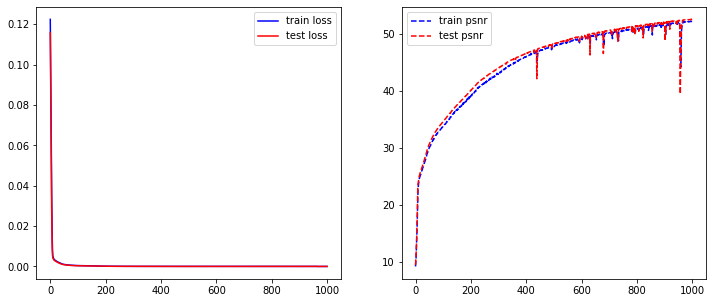

In [ ]:
#plot loss & psnr

_, ax = plt.subplots(1,2)
ax[0].plot(hist_loss_train, label='train loss', c='b')
ax[0].plot(hist_loss_test, label='test loss', c='r')
ax[0].legend()
ax[1].plot(hist_psnr_train, label='train psnr', c='b', linestyle='--')
ax[1].plot(hist_psnr_test, label='test psnr', c='r', linestyle='--')
ax[1].legend()
_.set_size_inches(12,5)

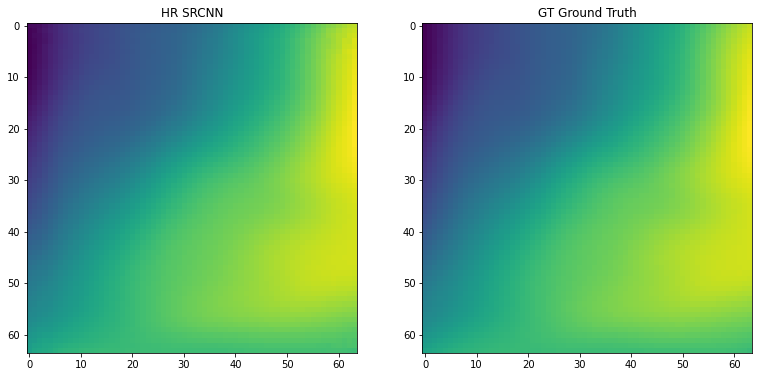

In [20]:
#plot example
tests, targets = next(iter(testloader))

GT = targets[0].squeeze()
HR = model(tests[0].float()).squeeze()

_, ax = plt.subplots(1,2)
ax[0].imshow(HR.detach().numpy())
ax[1].imshow(GT)
ax[0].title.set_text('HR SRCNN')
ax[1].title.set_text('GT Ground Truth')

_.set_size_inches(13,13)
plt.show()

In [21]:
#Errors

errors_L1 = []
error_L2 = 0

for i, (tests, targets) in enumerate(testloader):
  for idx in range(len(tests)):

    GT = targets[idx].squeeze().detach().numpy()
    HR = model(tests[idx].float()).squeeze().detach().numpy()
    
    errors_L1.append(np.abs((HR - GT) / GT))
    error_L2 += np.sqrt(((HR - GT)**2).sum() / (GT**2).sum())

errors_L1 = np.array(errors_L1)
error_L2 /= 56

Text(0.5, 0.98, 'relative L1 error')

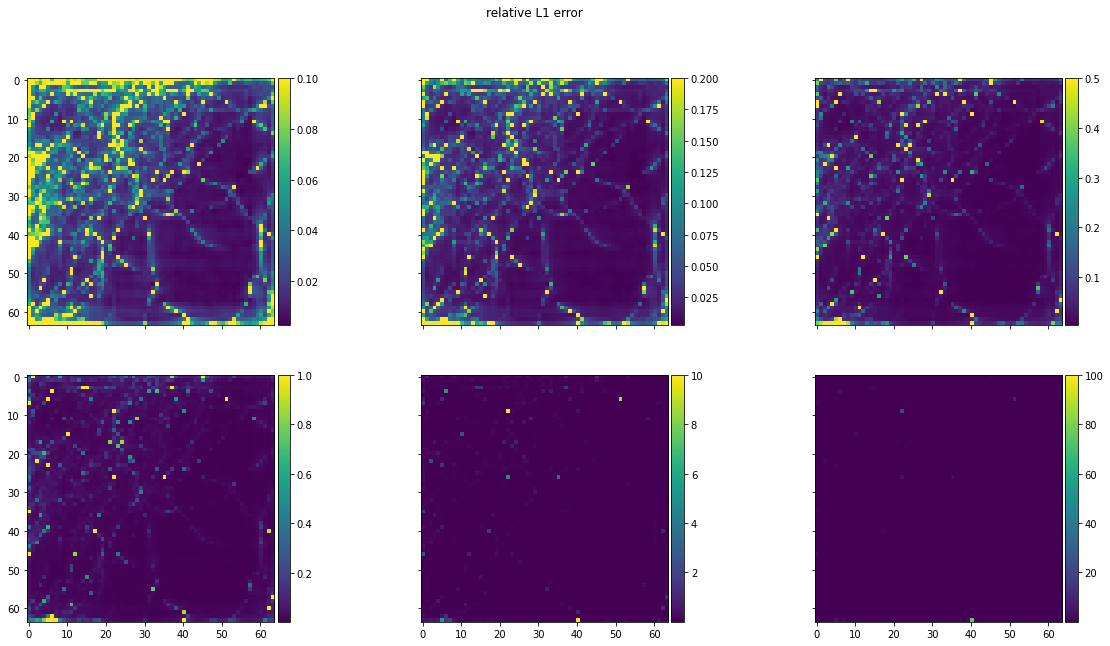

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(20,10))
MAX = [0.1, 0.2, 0.5, 1, 10, 100]

k=-1
im=[]
for i in range(2):
    for j in range(3):
        k += 1
        im.append(ax[i,j].imshow(errors_L1.mean(axis=0), vmax=MAX[k]))
        divider = make_axes_locatable(ax[i,j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im[k], cax=cax, orientation='vertical')

plt.suptitle('relative L1 error')

In [23]:
error_L2

0.01115854084640928

In [ ]:
#Errors with crop

CROP = transforms.CenterCrop(size=(55,55))

errors_L1 = []
error_L2 = 0

for i, (tests, targets) in enumerate(testloader):
  for idx in range(len(tests)):

    GT = CROP(targets[idx]).squeeze().detach().numpy()
    HR = CROP(model(tests[idx].float())).squeeze().detach().numpy()
    
    errors_L1.append(np.abs((HR - GT) / GT))
    error_L2 += np.sqrt(((HR - GT)**2).sum() / (GT**2).sum())

errors_L1 = np.array(errors_L1)
error_L2 /= 56

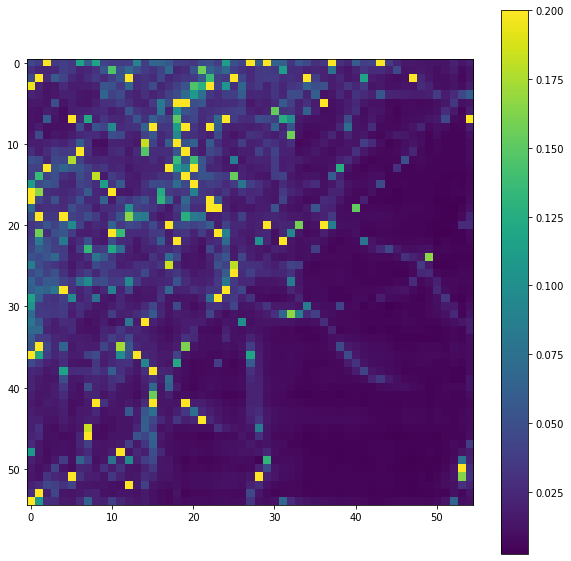

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(errors_L1.mean(axis=0), vmax=0.2)
plt.colorbar()

In [ ]:
error_L2

0.007165418286050378

In [ ]:
w.abs().mean()

tensor(0.2723, dtype=torch.float64)